# Section 1: Data Preprocessing

In [ ]:
import pandas as pd
from IPython.display import display

In [8]:
pd.set_option('display.max_rows', None)       # Show all rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.max_colwidth', None)   # Display full width of each cell
pd.set_option('display.width', None)          # Increase display width
pd.set_option('display.colheader_justify', 'left')        

In [ ]:
file = pd.read_csv(r'/incidents_train.csv')
file_copy = file.drop(file.columns[0], axis=1)

In [8]:
display(file_copy[['text', 'title', 'hazard-category', 'product-category' ,'hazard', 'product']].head(3))

,text,title,hazard-category,product-category,hazard,product
0,"Case Number: 024-94 \n Date Opened: 07/01/1994 \n Date Closed: 09/22/1994 \n \n Recall Class: 1 \n Press Release (Y/N): Y \n \n Domestic Est. Number: 05893 P \n Name: GERHARD'S NAPA VALLEY SAUSAGE\n \n Imported Product (Y/N): N \n Foreign Estab. Number: N/A\n \n City: NAPA \n State: CA \n Country: USA\n \n Product: SMOKED CHICKEN SAUSAGE\n \n Problem: BACTERIA \n Description: LISTERIA\n \n Total Pounds Recalled: 2,894 \n Pounds Recovered: 2,894",Recall Notification: FSIS-024-94,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,"Case Number: 033-94 \n Date Opened: 10/03/1994 \n Date Closed: 01/19/1995 \n \n Recall Class: 1 \n Press Release (Y/N): Y \n \n Domestic Est. Number: 05600 M \n Name: WIMMER'S MEAT PRODUCTS\n \n Imported Product (Y/N): N \n Foreign Estab. Number: N/A\n \n City: WEST POINT \n State: NE \n Country: USA\n \n Product: WIENERS\n \n Problem: BACTERIA \n Description: LISTERIA\n \n Total Pounds Recalled: 5,500 \n Pounds Recovered: 4,568",Recall Notification: FSIS-033-94,biological,"meat, egg and dairy products",listeria spp,sausage
2,"Case Number: 014-94 \n Date Opened: 03/28/1994 \n Date Closed: 07/19/1994 \n \n Recall Class: 1 \n Press Release (Y/N): Y \n \n Domestic Est. Number: 00819 M \n Name: WILLOW FOODS INC\n \n Imported Product (Y/N): N \n Foreign Estab. Number: N/A\n \n City: FALLS CITY \n State: NE \n Country: USA\n \n Product: HAM, SLICED\n \n Problem: BACTERIA \n Description: LISTERIA\n \n Total Pounds Recalled: 3,950 \n Pounds Recovered: 3,809",Recall Notification: FSIS-014-94,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices


In [10]:
# Display the number of unique categories in each column
print("Unique categories in 'product-category':", file_copy['product-category'].nunique())
print("Unique categories in 'hazard-category':", file_copy['hazard-category'].nunique())
print("Unique hazards in 'hazard':", file_copy['hazard'].nunique())
print("Unique products in 'product':", file_copy['product'].nunique())

Unique categories in 'product-category': 22
Unique categories in 'hazard-category': 10
Unique hazards in 'hazard': 128
Unique products in 'product': 1022


In [ ]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np 

# Initialize stemmer and lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '',text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_tokens]
    return ' '.join(lemmatized_tokens)


# Apply preprocessing to relevant columns
file_copy['processed_title'] = file_copy['title'].apply(preprocess_text)
file_copy['processed_long_text'] = file_copy['text'].apply(preprocess_text)

### **BERT**
- `BERT` reads the entire sentence both forward and backward, enabling it to grasp the full context of each word.
- `BertTokenizer` for text preprocessing.
- `BertModel` to generate embeddings.

In [61]:
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.detach().numpy()

# Apply BERT embeddings to processed columns
file_copy['bert_title_embeddings'] = file_copy['processed_title'].apply(get_bert_embeddings)
file_copy['bert_text_embeddings'] = file_copy['processed_long_text'].apply(get_bert_embeddings)

# Section 2: Train-Test Splitting and Benchmark Analyses

### 1. **Data Preparation**
The dataset is prepared for training and testing based on two distinct sources: **Titles** and **Texts**.

- **Using Titles**:
  - `X_train`: The `title` column serves as the feature set.
  - `Y_train`: The target variables are `hazard-category` and `hazard`, `product-category` and  `product`.

- **Using Texts**:
  - `X_train`: The `text` column is used as the feature set.
  - `Y_train`: The target variables are `hazard-category` and `hazard` `product-category` and  `product`.

---

### 2. **TF-IDF Vectorization**
- The `TfidfVectorizer` is employed to convert the text data into numerical feature matrices.
  - **Term Frequency (TF)**: Measures how often a word appears in a document (e.g., the `title` or `text`).
  - **Inverse Document Frequency (IDF)**: Penalizes common words by assigning higher importance to rarer terms.
  - This representation ensures that words appearing frequently across documents but not concentrated in any single document receive higher importance.

---

### 3. **Benchmark Analyses**

#### **Basic Machine Learning Algorithms**
1. **Logistic Regression**:
   - A simple and effective linear model for classification.
   - Suitable for linearly separable data and regularized by default to prevent overfitting.
   - Expected Performance: Reasonable baseline performance for simpler problems.
   
2. **Decision Trees**:
   - Builds a tree structure based on splitting features.
   - Easily interpretable but prone to overfitting if not pruned.
   - Expected Performance: Handles non-linear relationships better than Logistic Regression.

3. **Naive Bayes**:
   - A probabilistic classifier assuming feature independence.
   - Performs well for text classification tasks (e.g., spam filtering).
   - Expected Performance: Effective in text classification; struggles if feature independence is violated.

#### **Advanced Machine Learning Algorithms**
1. **Random Forest**:
   - Combines multiple decision trees to reduce overfitting.
   - Robust for most classification tasks, even with high-dimensional data.
   - Expected Performance: Typically among the best-performing algorithms.

2. **Support Vector Machines (SVM)**:
   - Finds the optimal hyperplane to separate classes.
   - Supports kernel tricks for non-linear problems but can be computationally expensive.
   - Expected Performance: Strong for small- to medium-sized datasets; may struggle with noisy or large data.

3. **Neural Networks (MLPClassifier)**:
   - Multi-layer perceptron (MLP) models non-linear relationships effectively.
   - Requires large datasets and careful tuning.
   - Expected Performance: Excels on complex tasks but may not outperform simpler models on smaller datasets.

---

### 4. **Expected Outcomes**
- **Best-performing models**:
  - Random Forest is expected to deliver robust results due to their ensemble nature.
- **Text Data**:
  - Naive Bayes is effective for text classification.
- **Simple or Linear Data**:
  - Logistic Regression and Decision Trees are suitable for smaller or simpler datasets.
  
---

# Explanation of the Code

### 1. **Feature and Target Definition**
- **Feature (`X`)**: The `processed_title/processed_long_text` column is selected as the input for the model.
- **Target (`y`)**: Two output columns, `hazard-category` and `product-category`, are selected as the target variables.

### 2. **Train-Test Split**
- The data is split into training and testing sets using `train_test_split` with **80% for training and 20% for testing**. The random state ensures reproducibility.
- The **`random_state`** parameter ensures that the data split is reproducible each time the code is run. Specifically, the `random_state` controls the randomness of the split, meaning that the same split can be achieved each time the code is executed with the same value for `random_state`.

### 3. **TF-IDF Vectorization**
- A `TfidfVectorizer` is initialized with the following parameters:
  - **`max_features=3000`**: Limits the vectorizer to use only the top 3000 features (words) based on their importance across the dataset.
  - This ensures the model focuses on the most relevant features and reduces dimensionality for efficiency.
- The vectorizer:
  - **Fits and transforms** the training data to create numerical representations.
  - **Transforms** the test data using the same vocabulary learned from the training data.
- The resulting sparse matrix is converted to a DataFrame for better visualization, with columns corresponding to the extracted features (words).

### 4. **BERT**
- Separate Input and Outputs with BERT Embeddings.
---

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the feature (title) and target (other columns)
X = file_copy['processed_title']  # Input: title column
X_t = file_copy['processed_long_text'] # Input: text column

y = file_copy[['hazard-category', 'product-category', 'hazard', 'product']]  
y_t = file_copy[['hazard-category', 'product-category', 'hazard', 'product']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.1, random_state=42)

# Initialize the TF-IDF vectorizer for converting text to numerical features
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2)) # ngram_range=(1, 2) : to capture more context and relationships between words.

# Fit and transform the training data, then transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) 

X_train_tfidf_t = vectorizer.fit_transform(X_train_t)
X_test_tfidf_t = vectorizer.transform(X_test_t)

In [68]:
# Define the feature: title, text, columns
X1 = np.stack(file_copy['bert_text_embeddings'].values)  # Input: text column
X1_t = np.stack(file_copy['bert_title_embeddings'].values) # Input: title column

y1 = file_copy[['hazard-category', 'product-category', 'hazard', 'product']]  
y1_t = file_copy[['hazard-category', 'product-category', 'hazard', 'product']]

# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)

X1_train_t, X1_test_t, y1_train_t, y1_test_t = train_test_split(X1_t, y1_t, test_size=0.1, random_state=42)

### 5.Hyperparameters

- Hyperparameters control the behavior of machine learning algorithms, including regularization, model complexity, and computational efficiency.
- **`param_grids`** defines the search space for hyperparameters for each algorithm.
- GridSearchCV and RandomizedSearchCV use these grids to find the optimal combination of parameters for the task.
---

### What is `param_grids` and What Do the Parameters Mean?

`param_grids` is a dictionary where:
- The **keys** are the names of the algorithms.
- The **values** are dictionaries specifying the hyperparameters for each algorithm and their possible values.

---

#### Explanation of Each Algorithm's Hyperparameters

1. **Logistic Regression**:
   - `"clf__estimator__C"`:
     - Regularization strength (inverse of regularization term).
     - Higher values = weaker regularization, allowing more complex models.
     - Lower values = stronger regularization, preventing overfitting.
   - `"clf__estimator__solver"`:
     - Algorithm used to optimize the model.
     - `"lbfgs"`: Suitable for smaller datasets.
     - `"saga"`: Supports large datasets and handles sparse data well.
     - `"liblinear"`: 

2. **Decision Tree**:
   - `"clf__estimator__max_depth"`:
     - Maximum depth of the tree.
     - Limits how deep the tree can grow, controlling overfitting.
     - `None`: Tree grows until all leaves are pure.
   - `"clf__estimator__min_samples_split"`:
     - Minimum number of samples required to split an internal node.
     - Higher values prevent the tree from growing too complex.

3. **Naive Bayes**:
   - No hyperparameters are tuned here because `MultinomialNB` typically does not have tunable hyperparameters.

4. **Random Forest**:
   - `"clf__estimator__n_estimators"`:
     - Number of trees in the forest.
     - More trees usually improve performance but increase computation time.
   - `"clf__estimator__max_depth"`:
     - Maximum depth of each tree (similar to Decision Tree).
   - `"clf__estimator__min_samples_split"`:
     - Minimum number of samples needed for a node to split (similar to Decision Tree).

5. **SVM (Support Vector Machine)**:
   - `"clf__estimator__C"`:
     - Regularization parameter (similar to Logistic Regression).
     - Controls the tradeoff between achieving a low error on training data and generalizing well.
   - `"clf__estimator__kernel"`:
     - The type of kernel function used (e.g., `"linear"`, `"rbf"`, `"poly"`).
     - Determines how the input space is transformed for separating classes.

6. **Neural Network**:
   - `"clf__estimator__hidden_layer_sizes"`:
     - The number of neurons in each hidden layer.
     - Examples:
       - `(100,)`: One hidden layer with 100 neurons.
       - `(50, 50)`: Two hidden layers, each with 50 neurons.
       - `(30, 30, 30)`: Three hidden layers, each with 30 neurons.
   - `"clf__estimator__activation"`:
     - The activation function used in the hidden layers.
     - `"relu"`: Rectified Linear Unit (default for most neural networks).
     - `"tanh"`: Hyperbolic tangent, useful for some datasets.

---

### What GridSearchCV and RandomizedSearchCV Do

#### GridSearchCV:
- **Purpose**: Exhaustively tests every combination of hyperparameters in a predefined grid to find the best-performing configuration.
- **Process**:
  - Takes a list of hyperparameters for a model.
  - Runs the model for every possible combination of the hyperparameters.
  - Evaluates each combination using the defined scoring metric (e.g., F1).
  - Selects the combination that yields the best score.

- **Pros**:
  - Guarantees the best combination within the grid is found.
- **Cons**:
  - Computationally expensive for large grids.

#### RandomizedSearchCV:
- **Purpose**: Randomly samples combinations of hyperparameters from a predefined grid.
- **Process**:
  - Instead of testing every possible combination, it selects a **fixed number of random combinations**.
  - Evaluates each combination and returns the best-performing one.

- **Pros**:
  - Faster and more efficient than GridSearchCV for large grids.
  - Can explore a broader range of values in less time.
- **Cons**:
  - May not find the absolute best combination due to randomness.

---

### Explanation of Estimator and Scoring in GridSearchCV/RandomizedSearchCV

#### Estimator
- In the context of **GridSearchCV** and **RandomizedSearchCV**, the `estimator` defines the machine learning pipeline that will be optimized.
- Here, the `estimator` is a **Pipeline**, which combines:
  1. **`TfidfVectorizer`**:
     - Converts the text data into numerical features using the Term Frequency-Inverse Document Frequency (TF-IDF) technique.
     - This ensures that the text is represented in a way suitable for machine learning algorithms.
  2. **`MultiOutputClassifier`**:
     - Wraps the specific classification algorithm (e.g., Logistic Regression, Decision Tree) to handle multi-label classification problems.
     - Allows the model to predict multiple output labels for each input sample.

#### Scoring Metric
- The `scoring` parameter specifies the metric used to evaluate the performance of the pipeline during hyperparameter tuning.
- Here, the **F1 score** is used as the scoring metric, specifically through a custom implementation, `multioutput_f1_scorer`.
- **Why Use F1 Score?**
  - F1 score is chosen because the task involves **imbalanced datasets**, where some classes are more frequent than others.
  - By balancing **precision** (avoiding false positives) and **recall** (avoiding false negatives), F1 ensures that the model performs well across all labels.
  - The custom implementation ensures that F1 is calculated for each output label individually, and the mean score is used for evaluation.
- **Why Not Use Other Metrics**:
  - **Accuracy**: Does not work well with imbalanced datasets.
  - **AUC-ROC**: While useful, it focuses on ranking predictions rather than their actual correctness for each label.
  - **Precision/Recall Alone**: Each only tells part of the story, whereas F1 combines them into a single metric.

---

In [66]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import UndefinedMetricWarning
import numpy as np
import pandas as pd
import warnings


warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Define basic algorithms
algorithms_basic = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": MultinomialNB(),
}

# Define advanced algorithms
algorithms_advanced = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000)
}

# Define hyperparameter space for each algorithm
# Define the parameter distributions 
param_grids = { 
        "Logistic Regression": { 
            "clf__estimator__C": [0.1, 1, 10, 20, 30, 50, 40], 
            "clf__estimator__solver": ["lbfgs", "liblinear", "saga"] 
                }, 
        "Decision Tree": { 
            "clf__estimator__max_depth": [None, 1, 5, 10, 20, 30],
            "clf__estimator__min_samples_split": [2, 5, 10] 
            }, 
        "Naive Bayes": {}, # No hyperparameters for tuning in MultinomialNB 
        "Random Forest": { 
            "clf__estimator__n_estimators": [10, 20, 30, 50, 100, 200], 
            "clf__estimator__max_depth": [None, 10, 20, 30], 
            "clf__estimator__min_samples_split": [2, 5, 10] 
            }, 
        "SVM": { 
            "clf__estimator__C": [0.1, 1, 10], 
            "clf__estimator__kernel": ["linear", "rbf", "poly"] 
            }, 
        "Neural Network": { 
            "clf__estimator__hidden_layer_sizes": [(100,), (50, 50), (30, 30, 30)], 
            "clf__estimator__activation": ["relu", "tanh"] 
            } 
        }
# Custom F1 scorer for multioutput
def custom_multioutput_f1(y_true, y_pred):
    y_true = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else np.array(y_true)
    y_pred = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else np.array(y_pred)
    f1_scores = [f1_score(y_true[:, i], y_pred[:, i], average='micro') for i in range(y_true.shape[1])]
    return np.mean(f1_scores)

multioutput_f1_scorer = make_scorer(custom_multioutput_f1)

# Function to train and evaluate algorithms
def algorithms_hyperparameter(algorithms, param_grids, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in algorithms.items():
        print(f"\nEvaluating {name}...")

        # Define pipeline
        pipeline = Pipeline([
            ('clf', MultiOutputClassifier(model, n_jobs=1))
        ])
        
        # Get hyperparameter grid for the algorithm
        param_dist = param_grids.get(name, {})
        
        if not param_dist:  # No hyperparameter tuning
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            # Evaluate each target separately
            target_results = {}
            for i, column in enumerate(y_test.columns):
                target_results[column] = classification_report(y_test[column], y_pred[:, i], output_dict=True)
            results[name] = target_results
            continue

        # Conditional search strategy
        if len(param_dist) * sum(len(v) for v in param_dist.values()) <= 20:
            search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_dist,
                cv=3,
                scoring=multioutput_f1_scorer,
                verbose=2
            )
        else:
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_dist,
                n_iter=20,
                cv=3,
                scoring=multioutput_f1_scorer,
                random_state=42,
                verbose=2
            )

        search.fit(X_train, y_train)
        
        print(f"Best Parameters for {name}:", search.best_params_)
    
    return results

# Evaluate basic and advanced algorithms
basic_results = algorithms_hyperparameter(algorithms_basic, param_grids, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)
advanced_results = algorithms_hyperparameter(algorithms_advanced, param_grids, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)


Evaluating Logistic Regression...
Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV] END clf__estimator__C=0.1, clf__estimator__solver=lbfgs; total time= 1.0min
[CV] END clf__estimator__C=0.1, clf__estimator__solver=lbfgs; total time= 1.2min
[CV] END clf__estimator__C=0.1, clf__estimator__solver=lbfgs; total time=  50.4s
[CV] END clf__estimator__C=0.1, clf__estimator__solver=liblinear; total time=  30.2s
[CV] END clf__estimator__C=0.1, clf__estimator__solver=liblinear; total time=  36.3s
[CV] END clf__estimator__C=0.1, clf__estimator__solver=liblinear; total time=  30.9s
[CV] END .clf__estimator__C=0.1, clf__estimator__solver=saga; total time= 3.0min
[CV] END .clf__estimator__C=0.1, clf__estimator__solver=saga; total time= 3.2min
[CV] END .clf__estimator__C=0.1, clf__estimator__solver=saga; total time= 2.8min
[CV] END ..clf__estimator__C=1, clf__estimator__solver=lbfgs; total time= 1.3min
[CV] END ..clf__estimator__C=1, clf__estimator__solver=lbfgs; total time= 1.2min
[

### 5. **Evaluation of Algorithms**
- The `evaluate_algorithms` function:
  - Accepts a dictionary of algorithms, the training data (`X_train`, `y_train`), and the test data (`X_test`, `y_test`).
  - Wraps each algorithm with `MultiOutputClassifier` to handle the multi-target nature of the problem (two output columns).
  - Trains the model using the training data and predicts the targets on the test data.
  - Evaluates each model for:
    - **Accuracy**: Measures how often the predictions are correct for each target.
    - **Classification Report**: Provides metrics such as precision, recall, and F1-score for each target.
- Results:
  - Metrics are stored in DataFrames and pivoted for a clearer comparison of each algorithm's performance across the targets.

### 6. **Types of Accuracy, Recall, Precision, and F1-Score**
The classification metrics are computed for each target column, and their types include:

#### **Accuracy**
-Accuracy is the fraction of the correctly classified instances in our sample. Shows how often a classification ML model is correct overall.

$$ Accuracy = (1 - Error Rate) = \frac{TP+TN}{TP+FP+TN+FN} $$
- Downside:
   -  It treats all classes as equally important and looks at all correct predictions. 

#### **Precision**
- Measures the proportion of positive predictions that are actually correct. Shows how often an ML model is correct when predicting the target class.
 
$$ P = \frac{TP}{TP+FP} $$

#### **Recall**
- Measures the proportion of actual positives that are correctly predicted.  Shows whether an ML model can find all objects of the target class.
 
$$ R = \frac{TP}{TP + FN} $$

#### **F1-Score**
- The harmonic mean of precision and recall, balancing their trade-off.

$$ F_1 = \frac{P \cdot R}{ P + R}$$
- Where:
    - \(P\) is **Precision**.
    - \(R\) is **Recall**.


### **Macro, Micro, and Weighted Averages in Classification**

In classification tasks, **precision**, **recall**, and **F1-score** can be averaged across multiple classes using different methods: **macro**, **micro**, and **weighted** averages. Each method provides different insights into model performance, especially in multi-class and imbalanced datasets.

#### Types of Averages:

1. **Macro Average**
   - **Description**: The metric is computed independently for each class, and then the average is taken across all classes. Each class is treated equally, regardless of the number of samples (support) in that class.
$$
\text{Macro Average} = \frac{1}{N} \sum_{i=1}^{N} \text{Metric}_i
$$
Where:
- \( N \) is the number of classes.
- $ \text{Metric}_i $ is the precision, recall, or F1-score for class \( i \).

   - **Use case**: Use when you care about performance on all classes equally, especially when evaluating performance on smaller classes.

2. **Micro Average**
   - **Description**: This method aggregates the contributions of all classes to compute the average, essentially by summing true positives, false positives, false negatives, and true negatives across all classes.
$$
\text{Micro Average} = \frac{\sum_{i=1}^{N} \text{True Positives}_i}{\sum_{i=1}^{N} (\text{True Positives}_i + \text{False Positives}_i + \text{False Negatives}_i)}
$$
Where:
- \( N \) is the number of classes.
- True Positives, False Positives, and False Negatives are summed across all classes.

   - **Use case**: Use when you want a global view of performance, and especially when class imbalance exists, as it treats the model's overall performance.

3. **Weighted Average**
   - **Description**: Like macro, it computes the metric for each class, but the average is weighted by the support (number of true instances) of each class, making larger classes have more influence on the final metric.
$$
\text{Weighted Average} = \frac{\sum_{i=1}^{N} \text{Support}_i \times \text{Metric}_i}{\sum_{i=1}^{N} \text{Support}_i}
$$   
Where:
- \( N \) is the number of classes.
- $ \text{Support}_i $ is the number of true instances of class \( i \).
- $ \text{Metric}_i $ is the precision, recall, or F1-score for class \( i \).

   - **Use case**: Use when you want to account for class imbalance while still measuring performance across all classes, giving more importance to the larger classes.

#### Comparison of Pros and Cons:

| **Metric**        | **Pros**                                                                 | **Cons**                                                                       |
|-------------------|--------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| **Macro Average** | - Treats all classes equally regardless of size.                         | - Sensitive to class imbalance; smaller classes can overly influence the result. |
|                   | - Useful for detecting poor performance in smaller classes.              | - Poor performance on minority classes can drag down the overall score.        |
| **Micro Average** | - Aggregates metrics across all classes, treating the entire dataset equally. | - Biased towards majority classes, as it aggregates all instances.             |
|                   | - Good for overall performance measure, especially for imbalanced datasets. | - Doesn't show per-class performance, may mask issues with small classes.      |
| **Weighted Average** | - Takes into account both the performance of each class and its support (size). | - Can be biased towards majority classes, masking poor performance in minority classes. |
|                   | - Useful for imbalanced datasets, balancing performance with class distribution. | - Smaller classes might have less impact despite poor performance.             |

#### Summary of When to Use:
- **Macro Average**: Use when you care about the performance across all classes equally, especially to detect poor performance on less frequent classes.
- **Micro Average**: Use for an overall performance measure, especially when class imbalance exists and you don't need per-class performance details.
- **Weighted Average**: Use when you care about how well the model performs on frequent classes, but still want to account for smaller classes in an imbalanced dataset.



### 7. **Purpose**
- This code prepares textual data for machine learning by transforming it into numerical form using TF-IDF.
- It trains and evaluates multiple machine learning models on a multi-target classification problem, providing insights into their performance.
---


### Differences Between `evaluate_algorithms` and `evaluate_models`

#### **1. Purpose and Focus**

- **`evaluate_algorithms`:**
  - Designed to evaluate multiple algorithms on multi-output classification problems.
  - Focuses on returning comprehensive evaluation metrics in the form of pivoted DataFrames (e.g., accuracies, precision, recall, F1-score).

- **`evaluate_models`:**
  - Similar functionality but provides a more detailed and verbose breakdown of metrics for each output class individually.
  - Generates and prints classification reports directly for better interpretability during execution.

---

In [69]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

def evaluate_algorithms(algorithms, X_train, y_train, X_test, y_test):
    # Initialize lists to store results
    accuracy_results = []
    classification_results = []
    best_estimators = {} # Dictionary to store the best estimators
    best_model = None  # To track the best model
    best_score = -float('inf')  # Initialize best score to a very low number

    # Loop through each algorithm and evaluate performance
    for algorithm_name, model in algorithms.items():
        print(f"\nTraining and evaluating {algorithm_name}...\n")
        
        # Wrap the model with MultiOutputClassifier if necessary (for multi-output labels)
        multi_target_model = MultiOutputClassifier(model, n_jobs=1)
        
        # Train the model
        multi_target_model.fit(X_train, y_train)

        # Predict on the test data
        y_pred = multi_target_model.predict(X_test)

        
        # Evaluate the model performance for each output column
        total_f1_score = 0  # Initialize total F2 score for the current model

        # Store accuracies for each algorithm and each target column
        for i, column in enumerate(y_test.columns):
            accuracy = round(accuracy_score(y_test[column], y_pred[:, i]), 3)
            accuracy_results.append({
                'Algorithm': algorithm_name,
                'Target': column,
                'Accuracy': accuracy
            })

            # Compute classification metrics
            precision = precision_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)
            recall = recall_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)
            f1 = f1_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)

            classification_results.append({
                'Algorithm': algorithm_name,
                'Target': column,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })

            # Track total F2 score for this model
            total_f1_score += f1
        
        # Check if the current model is the best based on the total F2-score
        if total_f1_score > best_score:
            best_score = total_f1_score
            best_model = multi_target_model
            best_estimators[algorithm_name] = multi_target_model

    # Convert results into DataFrames
    accuracy_df = pd.DataFrame(accuracy_results)
    classification_df = pd.DataFrame(classification_results)

    # Pivot the DataFrames
    accuracy_pivot = accuracy_df.pivot(index='Algorithm', columns='Target', values='Accuracy')
    classification_pivot = classification_df.pivot(index='Algorithm', columns='Target', values=['Precision', 'Recall', 'F1-Score'])

    return accuracy_pivot, classification_pivot, accuracy_results, classification_results, accuracy_df, classification_df, best_estimators, best_model

In [71]:
def evaluate_models(algorithms, X_train_tfidf, y_train, X_test_tfidf, y_test):

    best_estimators = {}  # Dictionary to store the best estimators
    best_model = None  # To track the best model
    best_score = -float('inf')  # Initialize best score to a very low number

    for algorithm_name, model in algorithms.items():
        print(f"\nTraining and evaluating {algorithm_name}...\n")
        
        # Wrap the model with MultiOutputClassifier for multi-output labels
        multi_target_model = MultiOutputClassifier(model, n_jobs=1)
        
        # Train the model
        multi_target_model.fit(X_train_tfidf, y_train)

        # Predict on the test data
        y_pred = multi_target_model.predict(X_test_tfidf)

        # Evaluate the model performance for each output column
        total_f1_score = 0  # Initialize total F2 score for the current model

        # Evaluate the model performance for each output column
        for i, column in enumerate(y_train.columns):
            accuracy = round(accuracy_score(y_test[column], y_pred[:, i]), 3)
            print(f"Accuracy for {column}: {accuracy}")

        
            print(f"Classification report for {column}:")
            # Compute the classification report as a dictionary
            report = classification_report(y_test[column], y_pred[:, i], output_dict=True, zero_division=1)

            # Round the report metrics to 3 decimals
            for key in report:
                if isinstance(report[key], dict):  # Check if it's a dictionary (class or avg)
                    for metric in ['precision', 'recall', 'f1-score', 'support']:
                        if metric in report[key]:
                            report[key][metric] = round(report[key][metric], 3)

            # Ensure accuracy is rounded to 3 decimals
            report['accuracy'] = round(report['accuracy'], 3)

            # Convert report dictionary to DataFrame for better visualization 
            report_df = pd.DataFrame(report).transpose() 
            # Use applymap to round numeric values for each column
            report_df = report_df.apply(lambda col: col.map(lambda x: round(x, 3) if isinstance(x, (int, float)) else x))
            
            print(report_df)

            # Calculate F1-Score for this column and add it to the total F1 score
            f1 = f1_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)
            total_f1_score += f1  # Add F1 score for this column to total


        # After evaluating each column, compute the average F1 score for the current model
        average_f1_score = total_f1_score / len(y_train.columns)
        print(f"Average F1-Score for {algorithm_name}: {round(average_f1_score, 3)}\n")

        # Track the best model based on F2 score
        if average_f1_score > best_score:
            best_score = average_f1_score
            best_model = multi_target_model

    # Store the best model in the dictionary
    best_estimators['best_model'] = best_model
    print("The best estimator is: ", best_estimators)

    return best_estimators

In [72]:
# algorithms_merged = {**algorithms_basic, **algorithms_advanced}
algorithms_merged = { "Logistic Regression": LogisticRegression(C=20, solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced'),
                      "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced'),
                      "Naive Bayes": MultinomialNB(),
                      "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42, class_weight='balanced'),
                      "SVM": SVC(C=1, kernel='linear', random_state=42, probability=True, class_weight='balanced'),
                      "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42)
}

In [73]:
# List of basic algorithms for classification
algorithms_basic = {
    "Logistic Regression": LogisticRegression(C=20, solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
}

# List of advanced algorithms for classification
algorithms_advanced = {
    "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42, class_weight='balanced'),
    "SVM": SVC(C=2, kernel='rbf', random_state=42, probability=True),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42)
}

# Section 3: Evaluation

### **Title:** Analysis of Machine Learning Algorithms

#### Overview: Basic vs. Advanced ML Algorithms

In [74]:
evaluate_models(algorithms_basic, X_train_tfidf, y_train, X_test_tfidf, y_test)


Training and evaluating Logistic Regression...

Accuracy for hazard-category: 0.831
Classification report for hazard-category:
                                precision  recall  f1-score  support
allergens                       0.856      0.915   0.884     188.000
biological                      0.860      0.901   0.880     171.000
chemical                        0.750      0.686   0.716      35.000
food additives and flavourings  1.000      0.200   0.333       5.000
foreign bodies                  0.843      0.741   0.789      58.000
fraud                           0.562      0.643   0.600      28.000
migration                       1.000      1.000   1.000       1.000
organoleptic aspects            1.000      0.000   0.000       3.000
other hazard                    0.800      0.533   0.640      15.000
packaging defect                1.000      0.400   0.571       5.000
accuracy                        0.831      0.831   0.831       0.831
macro avg                       0.867      0

{'best_model': MultiOutputClassifier(estimator=LogisticRegression(C=20,
                                                    class_weight='balanced',
                                                    max_iter=1000,
                                                    random_state=42),
                       n_jobs=1)}

In [75]:
evaluate_models(algorithms_advanced, X_train_tfidf, y_train, X_test_tfidf, y_test)


Training and evaluating Random Forest...

Accuracy for hazard-category: 0.815
Classification report for hazard-category:
                                precision  recall  f1-score  support
allergens                       0.841      0.899   0.869     188.000
biological                      0.790      0.901   0.842     171.000
chemical                        0.889      0.686   0.774      35.000
food additives and flavourings  0.500      0.200   0.286       5.000
foreign bodies                  0.870      0.690   0.769      58.000
fraud                           0.708      0.607   0.654      28.000
migration                       1.000      1.000   1.000       1.000
organoleptic aspects            0.000      0.000   0.000       3.000
other hazard                    0.875      0.467   0.609      15.000
packaging defect                0.667      0.400   0.500       5.000
accuracy                        0.815      0.815   0.815       0.815
macro avg                       0.714      0.585  

{'best_model': MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                        min_samples_split=10,
                                                        n_estimators=200,
                                                        random_state=42),
                       n_jobs=1)}

In [76]:
# Call the function with the basic algorithms
accuracy_pivot, classification_pivot, accuracy_results, classification_results, accuracy_df, classification_df, best_estimator, best_model = evaluate_algorithms(algorithms_merged, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot)

print("\nBest estimator is:\n")
print(best_estimator, best_model)


Training and evaluating Logistic Regression...


Training and evaluating Decision Tree...


Training and evaluating Naive Bayes...


Training and evaluating Random Forest...


Training and evaluating SVM...


Training and evaluating Neural Network...


Accuracy Results for all Algorithms:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Decision Tree        0.530   0.727            0.328    0.532           
Logistic Regression  0.666   0.833            0.422    0.723           
Naive Bayes          0.438   0.762            0.124    0.440           
Neural Network       0.627   0.819            0.403    0.699           
Random Forest        0.640   0.815            0.383    0.609           
SVM                  0.576   0.831            0.204    0.644           

Classification Report for all Algorithms:

                    Precision                                             \
Target      

### **Text:** Analysis of Machine Learning Algorithms

#### Overview: Basic vs. Advanced ML Algorithms

In [19]:
# Call the function with the basic algorithms
accuracy_pivot_t, classification_pivot_t, accuracy_results_t, classification_results_t, accuracy_df_t, classification_df_t, best_estimator_t, best_model_t = evaluate_algorithms(algorithms_basic, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot_t)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot_t)

print("\nBest estimator is:\n")
print(best_estimator_t, best_model_t)


Training and evaluating Logistic Regression...


Training and evaluating Decision Tree...


Training and evaluating Naive Bayes...


Accuracy Results for all Algorithms:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Decision Tree        0.706   0.828            0.259    0.503           
Logistic Regression  0.748   0.912            0.345    0.710           
Naive Bayes          0.395   0.754            0.089    0.426           

Classification Report for all Algorithms:

                    Precision                                             \
Target              hazard    hazard-category product   product-category   
Algorithm                                                                  
Decision Tree        0.584823  0.482091        0.489703  0.424641          
Logistic Regression  0.668389  0.837718        0.523896  0.639708          
Naive Bayes          0.979998  0.944198     

In [20]:
# Call the function with the basic algorithms
accuracy_pivot_t_2, classification_pivot_t_2, accuracy_results_t_2, classification_results_t_2, accuracy_df_t_2, classification_df_t_2, best_estimator_t2, best_model_t2 = evaluate_algorithms(algorithms_advanced, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot_t_2)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot_t_2)

print("\nBest estimator is:\n")
print(best_estimator_t2, best_model_t2)


Training and evaluating Random Forest...


Training and evaluating SVM...


Training and evaluating Neural Network...


Accuracy Results for all Algorithms:

Target          hazard  hazard-category  product  product-category
Algorithm                                                         
Neural Network  0.767   0.908            0.382    0.704           
Random Forest   0.794   0.891            0.388    0.584           
SVM             0.658   0.868            0.220    0.590           

Classification Report for all Algorithms:

               Precision                                            Recall     \
Target         hazard    hazard-category product   product-category hazard      
Algorithm                                                                       
Neural Network  0.775441  0.877510        0.609586  0.762159         0.431365   
Random Forest   0.745646  0.721005        0.546148  0.550501         0.531351   
SVM             0.927984  0.918459        0.935955  0.812

In [77]:
evaluate_models(algorithms_basic, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)


Training and evaluating Logistic Regression...

Accuracy for hazard-category: 0.925
Classification report for hazard-category:
                                precision  recall  f1-score  support
allergens                       0.957      0.941   0.949     188.000
biological                      0.965      0.977   0.971     171.000
chemical                        0.829      0.971   0.895      35.000
food additives and flavourings  1.000      0.200   0.333       5.000
foreign bodies                  0.950      0.983   0.966      58.000
fraud                           0.714      0.714   0.714      28.000
migration                       1.000      0.000   0.000       1.000
organoleptic aspects            0.667      0.667   0.667       3.000
other hazard                    0.733      0.733   0.733      15.000
packaging defect                0.667      0.400   0.500       5.000
accuracy                        0.925      0.925   0.925       0.925
macro avg                       0.848      0

{'best_model': MultiOutputClassifier(estimator=LogisticRegression(C=20,
                                                    class_weight='balanced',
                                                    max_iter=1000,
                                                    random_state=42),
                       n_jobs=1)}

In [78]:
evaluate_models(algorithms_advanced, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)


Training and evaluating Random Forest...

Accuracy for hazard-category: 0.908
Classification report for hazard-category:
                                precision  recall  f1-score  support
allergens                       0.958      0.973   0.966     188.000
biological                      0.948      0.965   0.957     171.000
chemical                        0.909      0.857   0.882      35.000
food additives and flavourings  1.000      0.200   0.333       5.000
foreign bodies                  0.866      1.000   0.928      58.000
fraud                           0.708      0.607   0.654      28.000
migration                       1.000      0.000   0.000       1.000
organoleptic aspects            0.000      0.000   0.000       3.000
other hazard                    0.538      0.467   0.500      15.000
packaging defect                0.250      0.200   0.222       5.000
accuracy                        0.908      0.908   0.908       0.908
macro avg                       0.718      0.527  

{'best_model': MultiOutputClassifier(estimator=MLPClassifier(max_iter=1000, random_state=42),
                       n_jobs=1)}

##### Comparison of Basic-Advanced ML Algorithms

In [21]:
accuracy_df_comparison_t = pd.DataFrame(accuracy_results_t + accuracy_results_t_2)
classification_df_comparison_t = pd.DataFrame(classification_results_t + classification_results_t_2)

# Pivot the accuracy DataFrame to show one row per algorithm and one column per target
accuracy_pivot_comparison_t = accuracy_df_comparison_t.pivot(index='Algorithm', columns='Target', values='Accuracy')

# Pivot the classification DataFrame to show one row per algorithm and columns for Precision, Recall, F1-Score for each target
classification_pivot_comparison_t = classification_df_comparison_t.pivot(index='Algorithm', columns='Target', values=['Precision', 'Recall', 'F1-Score'])

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot_comparison_t)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot_comparison_t)


Accuracy Results for all Algorithms:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Decision Tree        0.706   0.828            0.259    0.503           
Logistic Regression  0.748   0.912            0.345    0.710           
Naive Bayes          0.395   0.754            0.089    0.426           
Neural Network       0.767   0.908            0.382    0.704           
Random Forest        0.794   0.891            0.388    0.584           
SVM                  0.658   0.868            0.220    0.590           

Classification Report for all Algorithms:

                    Precision                                             \
Target              hazard    hazard-category product   product-category   
Algorithm                                                                  
Decision Tree        0.584823  0.482091        0.489703  0.424641          
Logistic Regression  0.668389  0.8377

### Bert Results-Text Analysis

In [79]:
algorithms = {
    "Logistic Regression":LogisticRegression(C=20, solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced'),
    "SVM": SVC(C=2, kernel='linear', random_state=42, probability=True, class_weight='balanced'),
    "Random Forest ": RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42, class_weight='balanced')
}

In [81]:
# Evaluate Logistic Regression
accuracy_pivot_bert, classification_pivot_bert, accuracy_results_bert, classification_results_bert, accuracy_df_bert, classification_df_bert, best_estimators_bert, best_model_bert = evaluate_algorithms(
    algorithms, X1_train_t, y1_train_t, X1_test_t, y1_test_t
)

# Display the results
print("\nAccuracy Results for Logistic Regression:\n")
print(accuracy_pivot_bert)

print("\nClassification Report for Logistic Regression:\n")
print(classification_pivot_bert)

print("\nBest estimator is:\n")
print(best_estimators_bert)
print(best_model_bert)


Training and evaluating Logistic Regression...


Training and evaluating SVM...


Training and evaluating Random Forest ...


Accuracy Results for Logistic Regression:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Logistic Regression  0.534   0.747            0.324    0.542           
Random Forest        0.483   0.735            0.081    0.499           
SVM                  0.532   0.776            0.299    0.582           

Classification Report for Logistic Regression:

                    Precision                                             \
Target              hazard    hazard-category product   product-category   
Algorithm                                                                  
Logistic Regression  0.470362  0.625741        0.531830  0.483967          
Random Forest        0.567839  0.872466        0.407325  0.629012          
SVM                  0.528335  0.629595  

# Section 4: Visualization

## **Overview**
This section provides a detailed comparison of:
1. **Basic vs. Advanced ML Algorithms**
2. **Text Analysis vs. Title Analysis**

---

### AUC-ROC

#### What is AUC-ROC?
- **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)** is a popular diagnostic tool for evaluating the performance of binary classification models.
- It measures the ability of a model to differentiate between positive and negative classes across all classification thresholds.
- The **ROC curve** plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at different thresholds, and the **AUC** (Area Under the Curve) summarizes this curve into a single number, representing the overall quality of the model.

---

#### Understanding the ROC Curve
- The **ROC Curve (Receiver Operating Characteristic)** plots:
  - **True Positive Rate (TPR)** (y-axis): The proportion of actual positives correctly classified.
  - **False Positive Rate (FPR)** (x-axis): The proportion of actual negatives incorrectly classified as positives.
- Each point on the ROC curve represents the TPR and FPR for a specific classification threshold.

#### Ideal and Poor Curves
1. **Ideal Curve**:
   - An ideal classifier's ROC curve will closely approach the **top-left corner** of the plot, where TPR = 1 and FPR = 0.
   - This indicates perfect classification of all positive and negative instances.
   - AUC (Area Under the Curve) in this case will be **close to 1.0**, representing excellent performance.

2. **Poor Curve**:
   - If the ROC curve is more diagonal or linear (closer to the **45-degree line**), the classifier's performance is similar to random guessing.
   - In such cases, the AUC score will be closer to **0.5**, indicating poor classification ability.

3. **General Rule**:
   - The **closer the curve is to 1**, the better the model's ability to differentiate between classes.
   - A linear or diagonal curve suggests worse performance, often indistinguishable from a random model.

---

#### Advantages of AUC-ROC
1. **Single Number Summary**:
   - The AUC score provides a single number that reflects the overall model quality, making it easy to compare multiple models.

2. **Effective for Imbalanced Data**:
   - AUC-ROC assesses the model's ability to rank predictions correctly, regardless of the class imbalance in the dataset.

3. **Resistant to Class Distribution Drift**:
   - Unlike metrics like precision and recall, AUC-ROC remains stable even if the class distribution changes over time.

---

#### Disadvantages of AUC-ROC
1. **Misleading in Severe Imbalances**:
   - When the positive class is extremely small, AUC-ROC can overestimate model performance by emphasizing the correct classification of the majority class.

2. **Cost of Errors**:
  - AUC-ROC does not differentiate between the costs of false positives (FP) and false negatives (FN).

---

#### Conclusion
- AUC-ROC is a robust and widely used metric, particularly suited for binary classification problems with moderate class imbalance and no specific cost constraints.
- For scenarios where error costs or severe class imbalances are critical, alternative metrics like F1-score, precision, or recall might be more appropriate.

---

In [58]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for each category
class_weights = compute_class_weight('balanced', classes=np.unique(y['product-category']), y=y['product-category'])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# algorithms_merged = {**algorithms_basic, **algorithms_advanced}
algorithms_merged = { "Logistic Regression": LogisticRegression(C=10, solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced'),
                      "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=5, random_state=42,  class_weight='balanced'),
                      "Naive Bayes": MultinomialNB(),
                      "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42,  class_weight='balanced'),
                      "SVM": SVC(C=2, kernel='linear', random_state=42, probability=True,  class_weight='balanced'),
                      "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42)
}

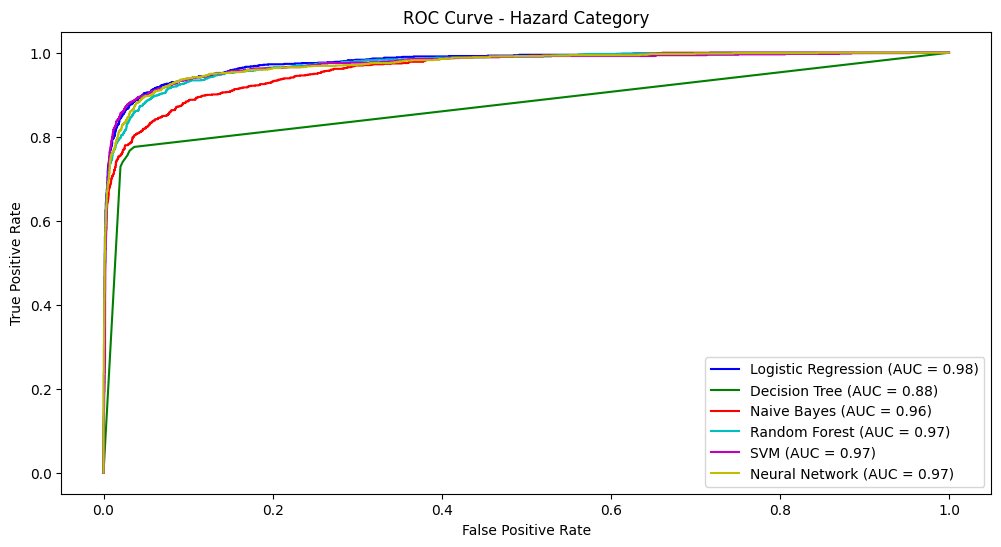

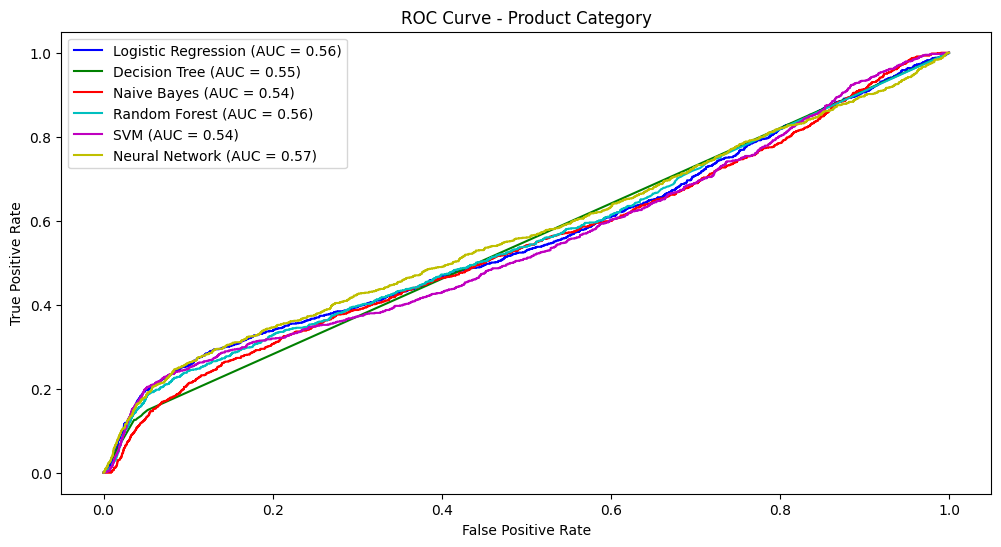

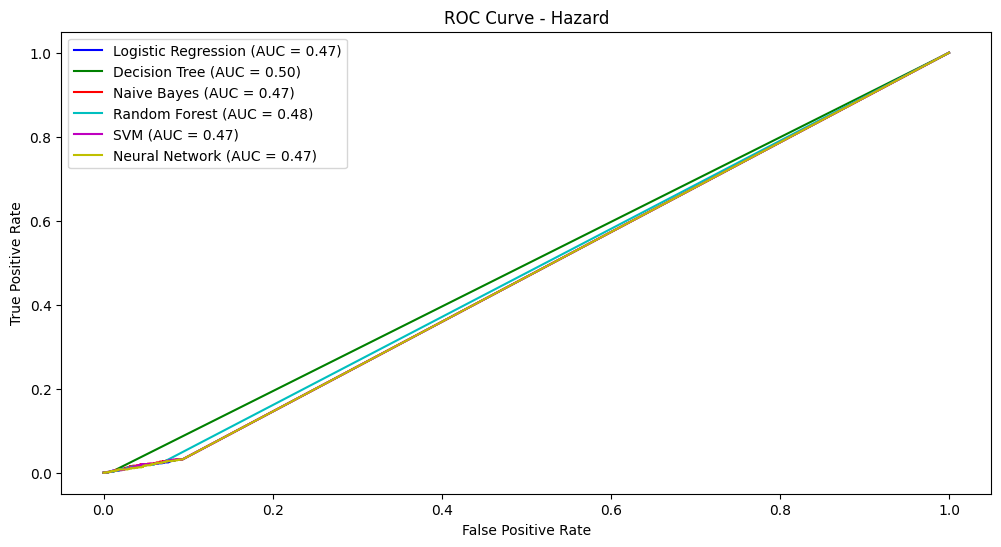

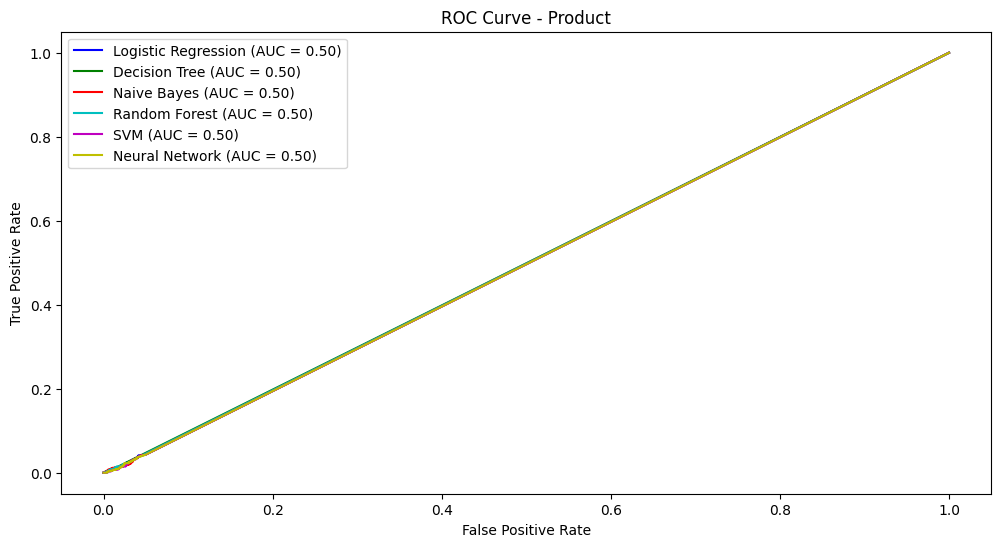

In [63]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier

# Initialize label binarizers
label_binarizer_hazard = LabelBinarizer()
label_binarizer_product = LabelBinarizer()

# Binarize labels
y_test_hazard_cat_bin = label_binarizer_hazard.fit_transform(y_test['hazard-category'])
y_test_hazard_bin = label_binarizer_hazard.fit_transform(y_test['hazard'])
y_test_product_cat_bin = label_binarizer_product.fit_transform(y_test['product-category'])
y_test_product_bin = label_binarizer_product.fit_transform(y_test['product'])

# Colors for plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot for Hazard-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test), y_test_hazard_cat_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_cat_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test), y_test_product_cat_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_cat_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Hazard
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test), y_test_hazard_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test), y_test_product_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


###  `plot_metrics` Function

The `plot_metrics` function is designed to visually represent the performance of various machine learning algorithms across different evaluation metrics and target categories. Here's a breakdown of its purpose:

1. **Data Transformation**:
   - Converts the `classification_pivot` DataFrame into a long format suitable for plotting, splitting metrics by algorithm, target category, and metric value.
   - Processes `accuracy_pivot` data similarly, combining accuracy metrics with other classification metrics for unified visualization.

2. **Combination of Metrics**:
   - Merges accuracy metrics with other evaluation metrics (e.g., precision, recall, F1-score) into a single dataset for easier comparison.

3. **Visualization**:
   - Uses **seaborn's barplot** to create side-by-side bar charts for each target category, comparing algorithm performance across metrics.
   - Displays these plots on multiple subplots, with one subplot per target category.

4. **Customization**:
   - Titles, labels, legends, and axis limits are set to enhance clarity and interpretability.

5. **Output**:
   - Produces a figure with a clear comparison of algorithm performance across multiple evaluation metrics for different categories, facilitating insights into model effectiveness.

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

def plots(classification_pivot, accuracy_pivot, categories):
    # Convert classification_pivot to a long format for plotting
    classification_long = classification_pivot.melt(ignore_index=False).reset_index()
    classification_long.columns = ['Algorithm', 'Metric', 'Target', 'Value']

    # Prepare accuracy data for each target category
    accuracy_long = accuracy_pivot.reset_index().melt(id_vars='Algorithm', var_name='Target', value_name='Value')
    accuracy_long['Metric'] = 'Accuracy'

    # Combine classification metrics with accuracy metrics
    combined_metrics = pd.concat([classification_long, accuracy_long])

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(24, 10))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        # Filter data for the current category
        data = combined_metrics[combined_metrics['Target'] == category]

        # Plotting
        sns.barplot(
            data=data, 
            x="Algorithm", 
            y="Value", 
            hue="Metric", 
            ax=axes[i], 
            palette="Set2"
        )

        axes[i].set_title(f"Performance Metrics for {category}", fontsize=16)
        axes[i].set_xlabel("Algorithm", fontsize=14)
        axes[i].set_ylabel("Metric Value", fontsize=14)
        axes[i].legend(title="Metric", fontsize=12)
        axes[i].set_ylim(0, 1)

    # Layout and show
    plt.tight_layout()
    plt.show()

    # Accuracy heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(accuracy_pivot, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
    plt.title("Accuracy Heatmap Across Algorithms and Targets")
    plt.ylabel("Algorithm")
    plt.xlabel("Target")
    plt.show()

    # Extract F1-Score Pivot
    f1_pivot = classification_pivot['F1-Score']
    precision = classification_pivot['Precision']
    recall= classification_pivot['Recall']

    plt.figure(figsize=(10, 6))
    sns.heatmap(f1_pivot, annot=True, fmt=".3f", cmap="coolwarm",center=0, cbar=True)
    plt.title("F1-Score Heatmap Across Algorithms and Targets")
    plt.ylabel("Algorithm")
    plt.xlabel("Target")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(precision, annot=True, fmt=".3f", cmap="Accent",center=2, cbar=True)
    plt.title("Precision Heatmap Across Algorithms and Targets")
    plt.ylabel("Algorithm")
    plt.xlabel("Target")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(recall, annot=True, fmt=".3f", cmap="Accent",center=2, cbar=True)
    plt.title("Recall Heatmap Across Algorithms and Targets")
    plt.ylabel("Algorithm")
    plt.xlabel("Target")
    plt.show()

    # Calculate average scores per algorithm (across all metrics and targets)
    average_scores = classification_pivot.mean(axis=1).reset_index()
    average_scores.columns = ['Algorithm', 'Average Score']

    plt.figure(figsize=(10, 6))
    sns.barplot(data=average_scores, x='Algorithm', y='Average Score', palette="viridis")
    plt.title("Average Scores per Algorithm")
    plt.ylabel("Average Score")
    plt.xlabel("Algorithm")
    plt.show()


## Title Analysis

### Comparison of both Basic-Advanced ML Algorithms

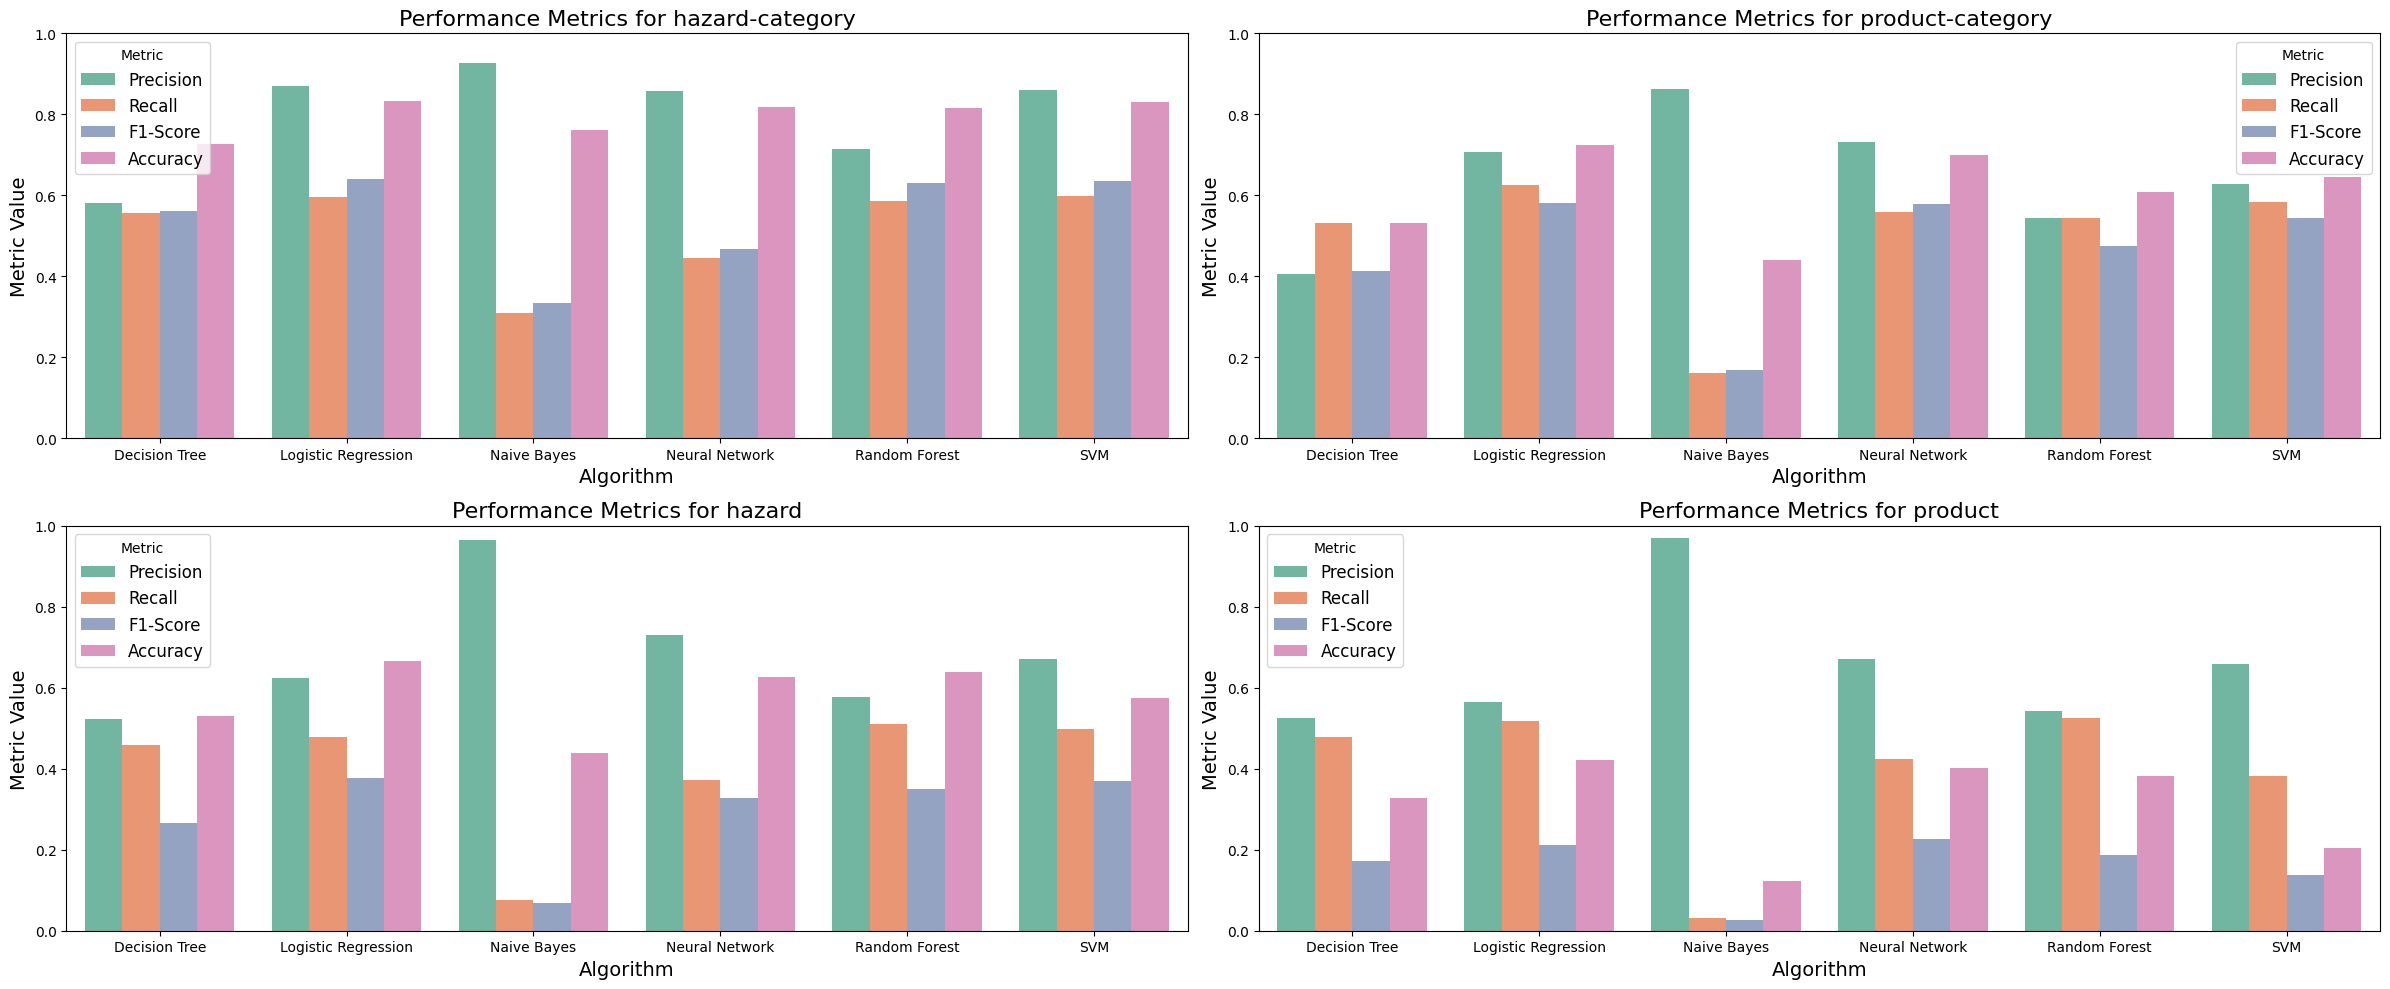

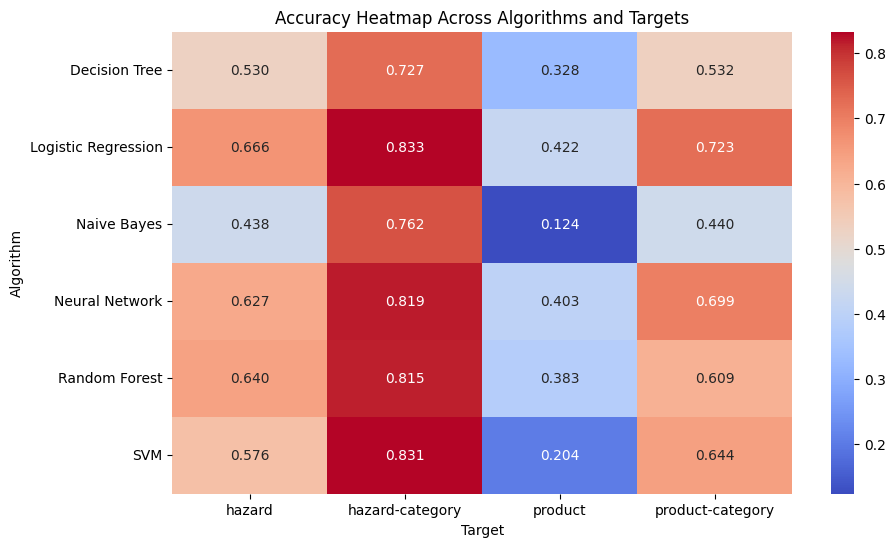

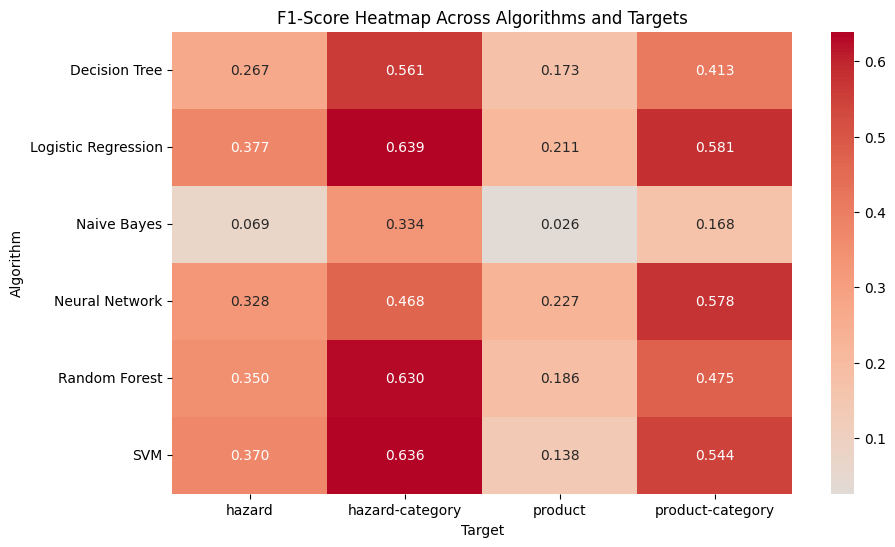

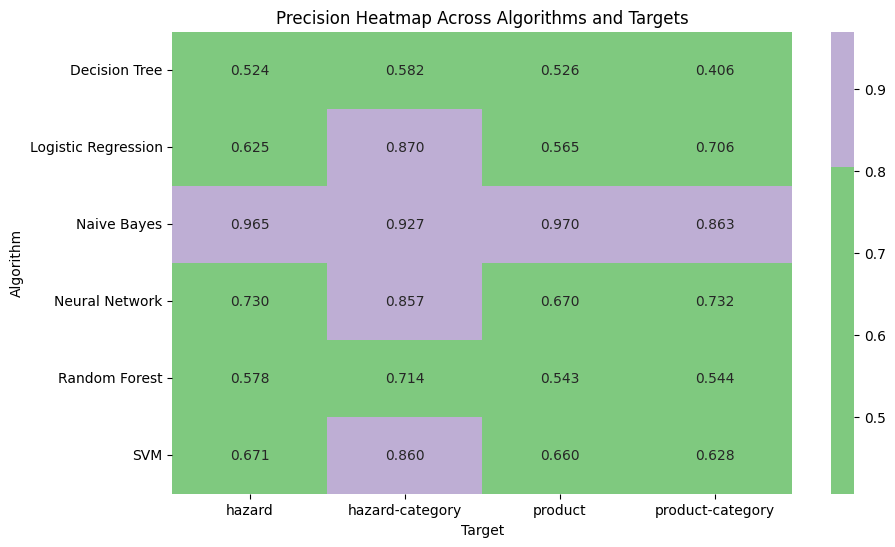

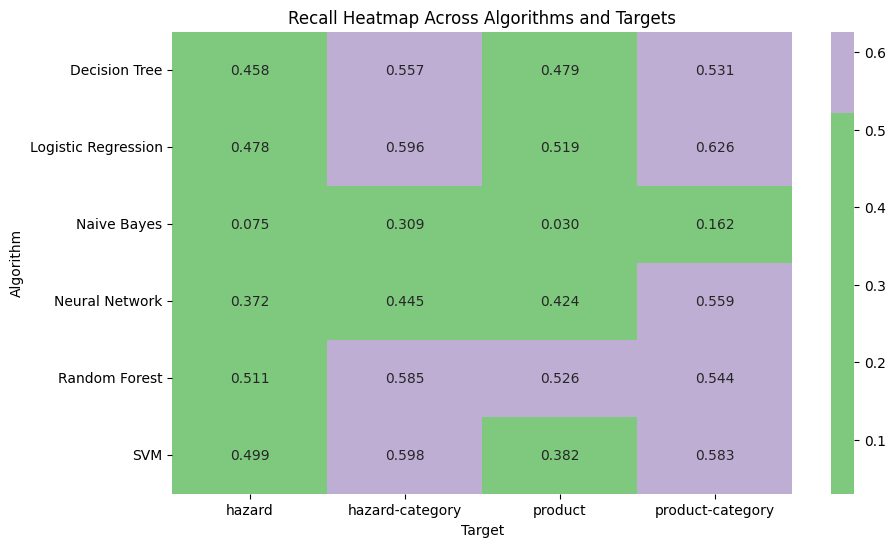

C:\Users\maria\AppData\Local\Temp\ipykernel_24156\888303424.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_scores, x='Algorithm', y='Average Score', palette="viridis")


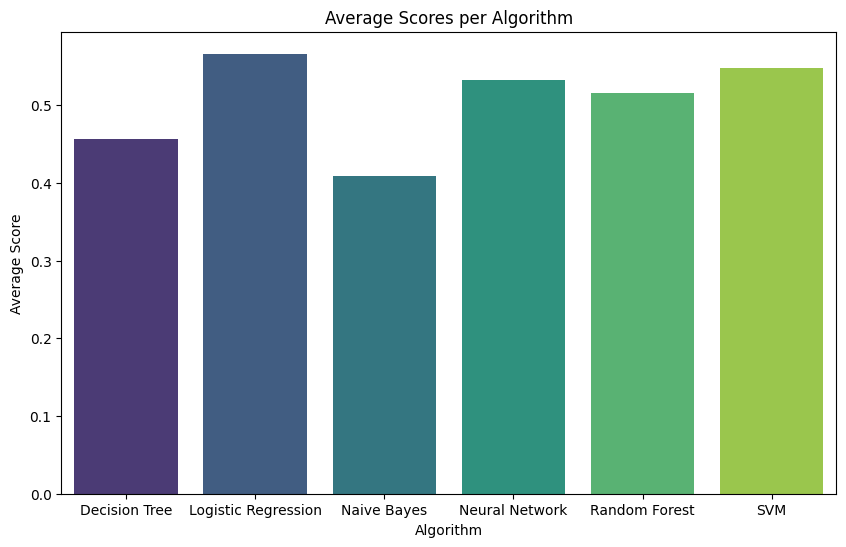

In [83]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plots(classification_pivot, accuracy_pivot, categories)

## Text Analysis

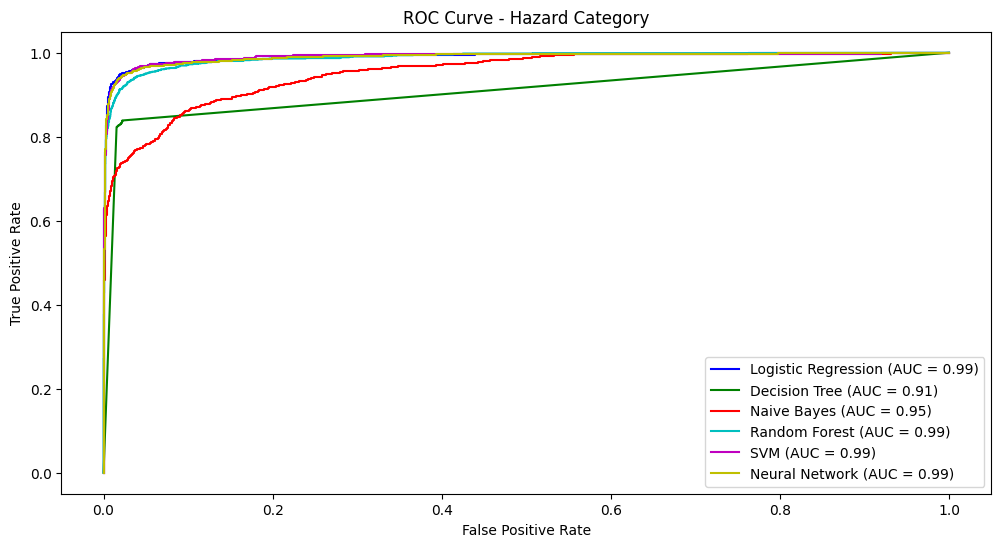

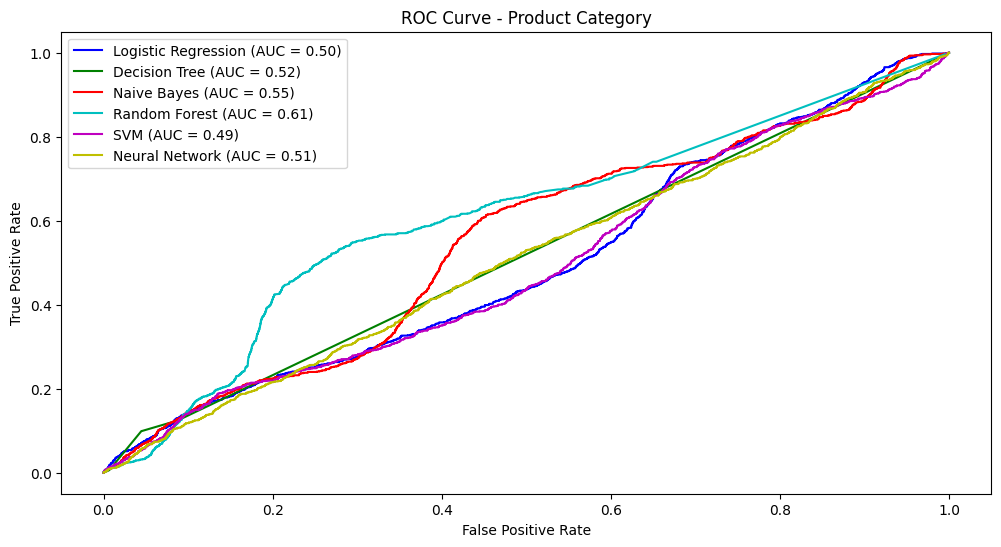

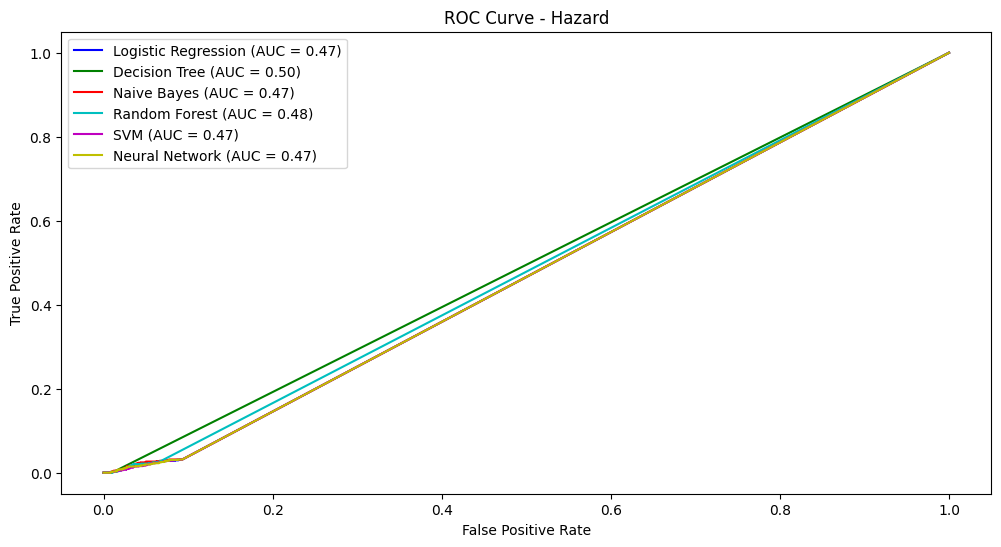

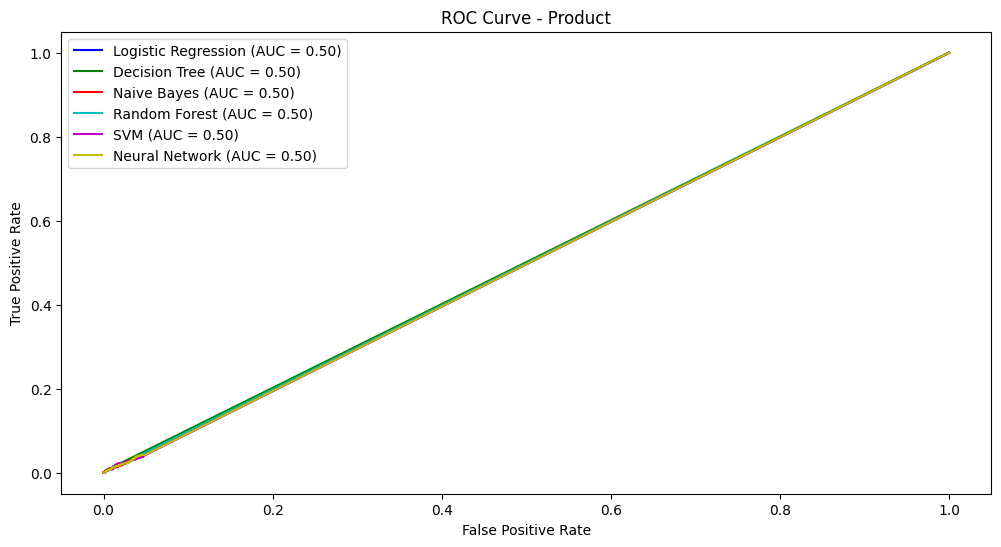

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier

# Initialize label binarizers
label_binarizer_hazard = LabelBinarizer()
label_binarizer_product = LabelBinarizer()

# Binarize labels
y_test_hazard_cat_bin = label_binarizer_hazard.fit_transform(y_test_t['hazard-category'])
y_test_product_cat_bin = label_binarizer_product.fit_transform(y_test_t['product-category'])
y_test_hazard_bin = label_binarizer_hazard.fit_transform(y_test_t['hazard'])
y_test_product_bin = label_binarizer_product.fit_transform(y_test_t['product'])

# Colors for plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot for Hazard_Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf_t, y_train_t)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test_t), y_test_hazard_cat_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_cat_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test_t), y_test_product_cat_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_cat_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Hazard
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf_t, y_train_t)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test_t), y_test_hazard_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test_t), y_test_product_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Comparison of both Basic-Advanced ML Algorithms 

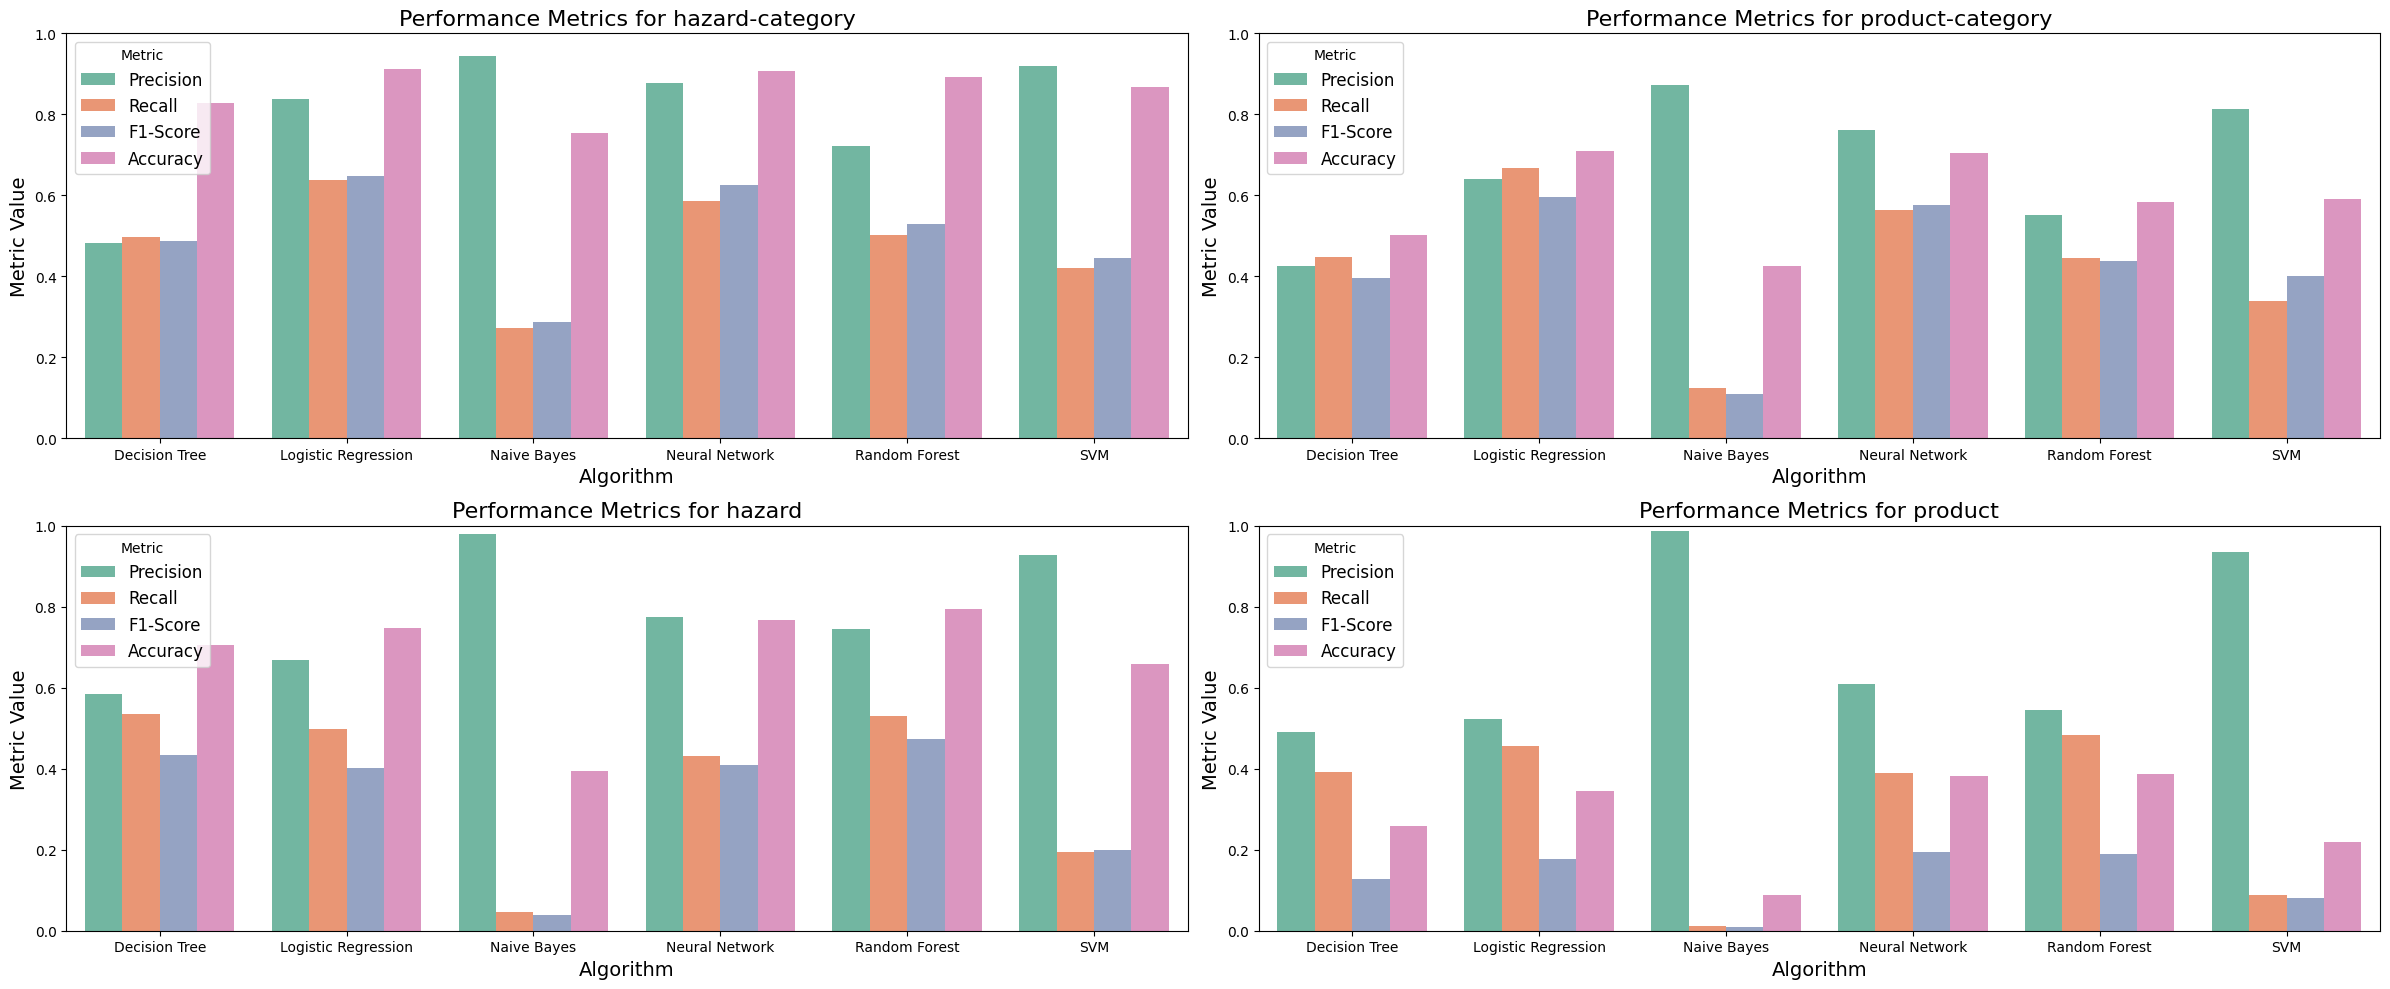

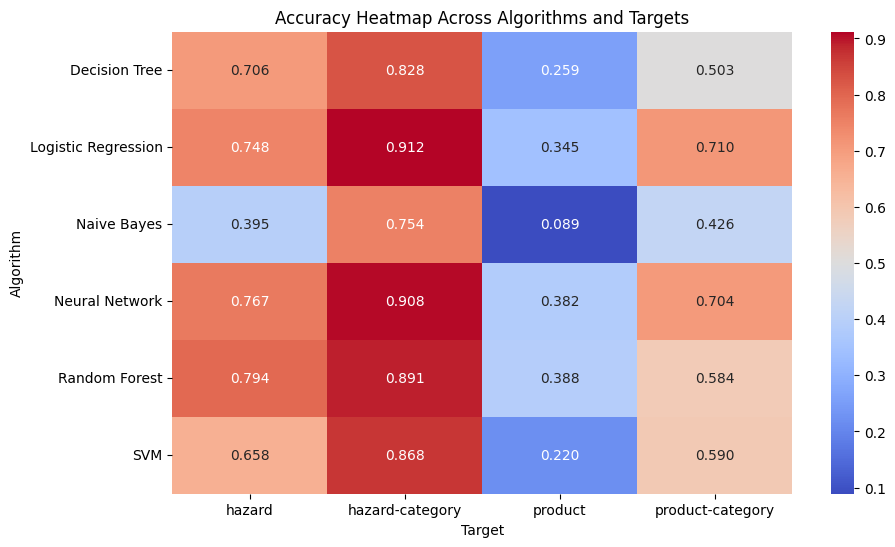

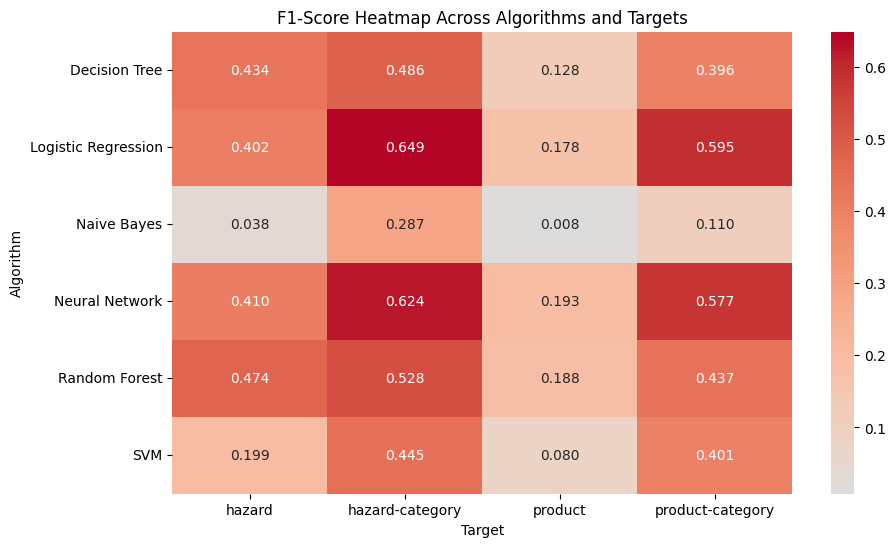

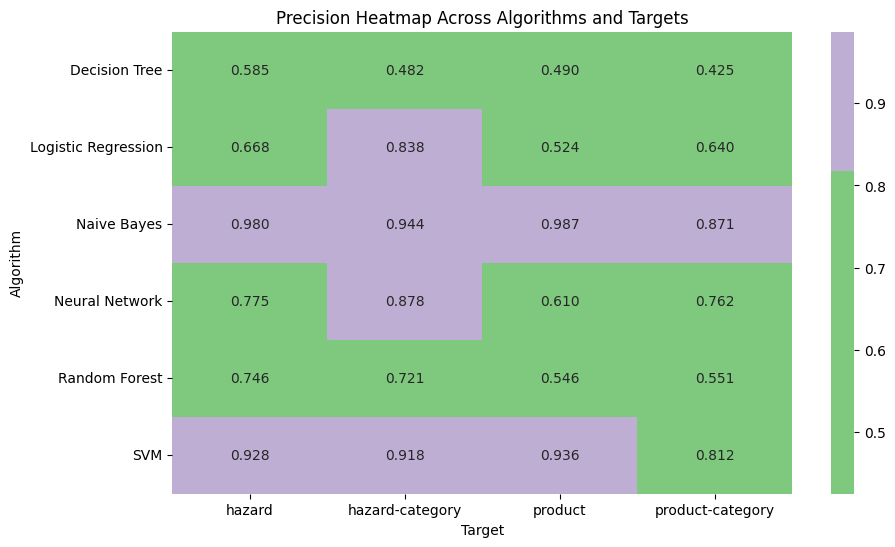

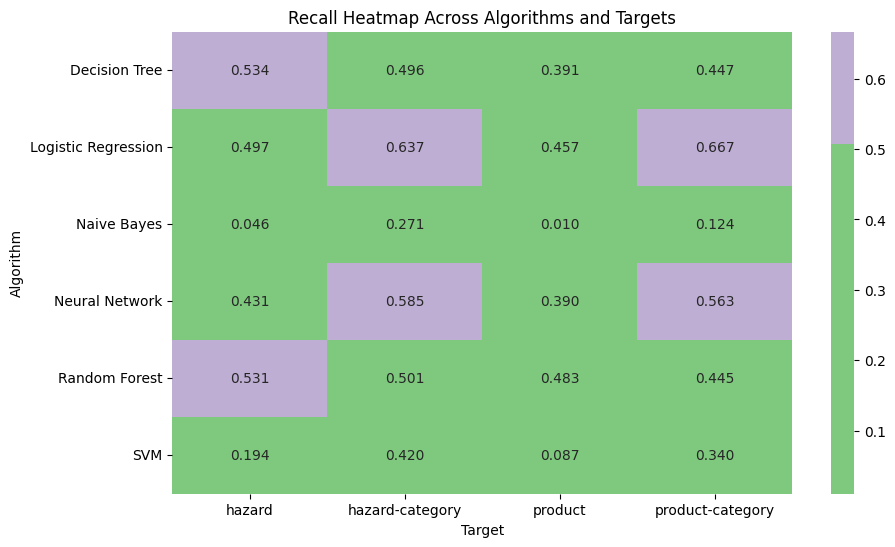

C:\Users\maria\AppData\Local\Temp\ipykernel_24156\888303424.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_scores, x='Algorithm', y='Average Score', palette="viridis")


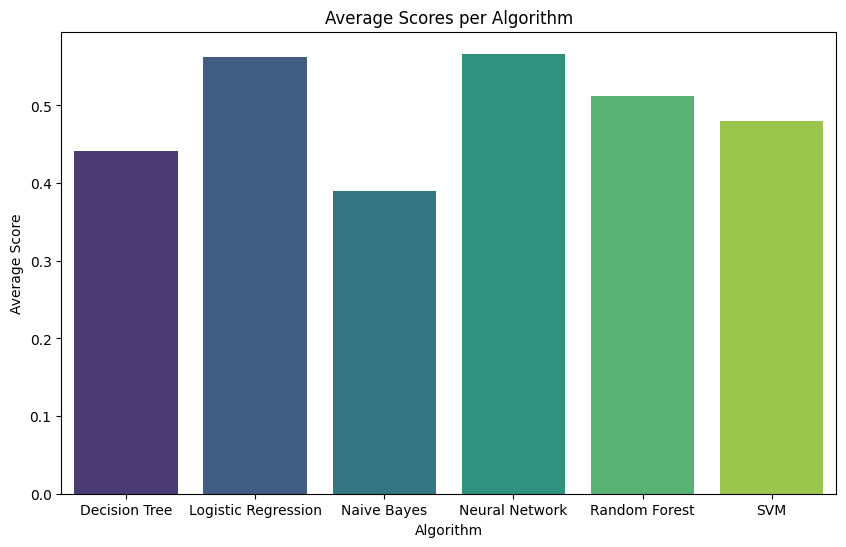

In [24]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plots(classification_pivot_comparison_t, accuracy_pivot_comparison_t, categories)

## Text-Title Comparison

### Comparison of All ML Algorithms (Basic to Advanced) 

In [84]:
# Add a column to differentiate between text and title analysis
classification_df_t['Analysis'] = 'Text Analysis'
accuracy_df_t['Analysis'] = 'Text Analysis'
classification_df['Analysis'] = 'Title Analysis'
accuracy_df['Analysis'] = 'Title Analysis'
classification_df_t_2['Analysis'] = 'Text Analysis'
accuracy_df_t_2['Analysis'] = 'Text Analysis'



# Combine the classification and accuracy DataFrames for both analyses
combined_classification_df = pd.concat([classification_df_t, classification_df, classification_df_t_2])
combined_accuracy_df = pd.concat([accuracy_df_t, accuracy_df, accuracy_df_t_2])

# Pivot the combined DataFrames
combined_classification_pivot = combined_classification_df.pivot_table(index=['Algorithm', 'Analysis'], columns='Target', values=['Precision', 'Recall', 'F1-Score'])
combined_accuracy_pivot = combined_accuracy_df.pivot_table(index=['Algorithm', 'Analysis'], columns='Target', values='Accuracy')

# Flatten the MultiIndex columns for easier handling
combined_classification_pivot.columns = ['_'.join(col).strip() for col in combined_classification_pivot.columns.values]

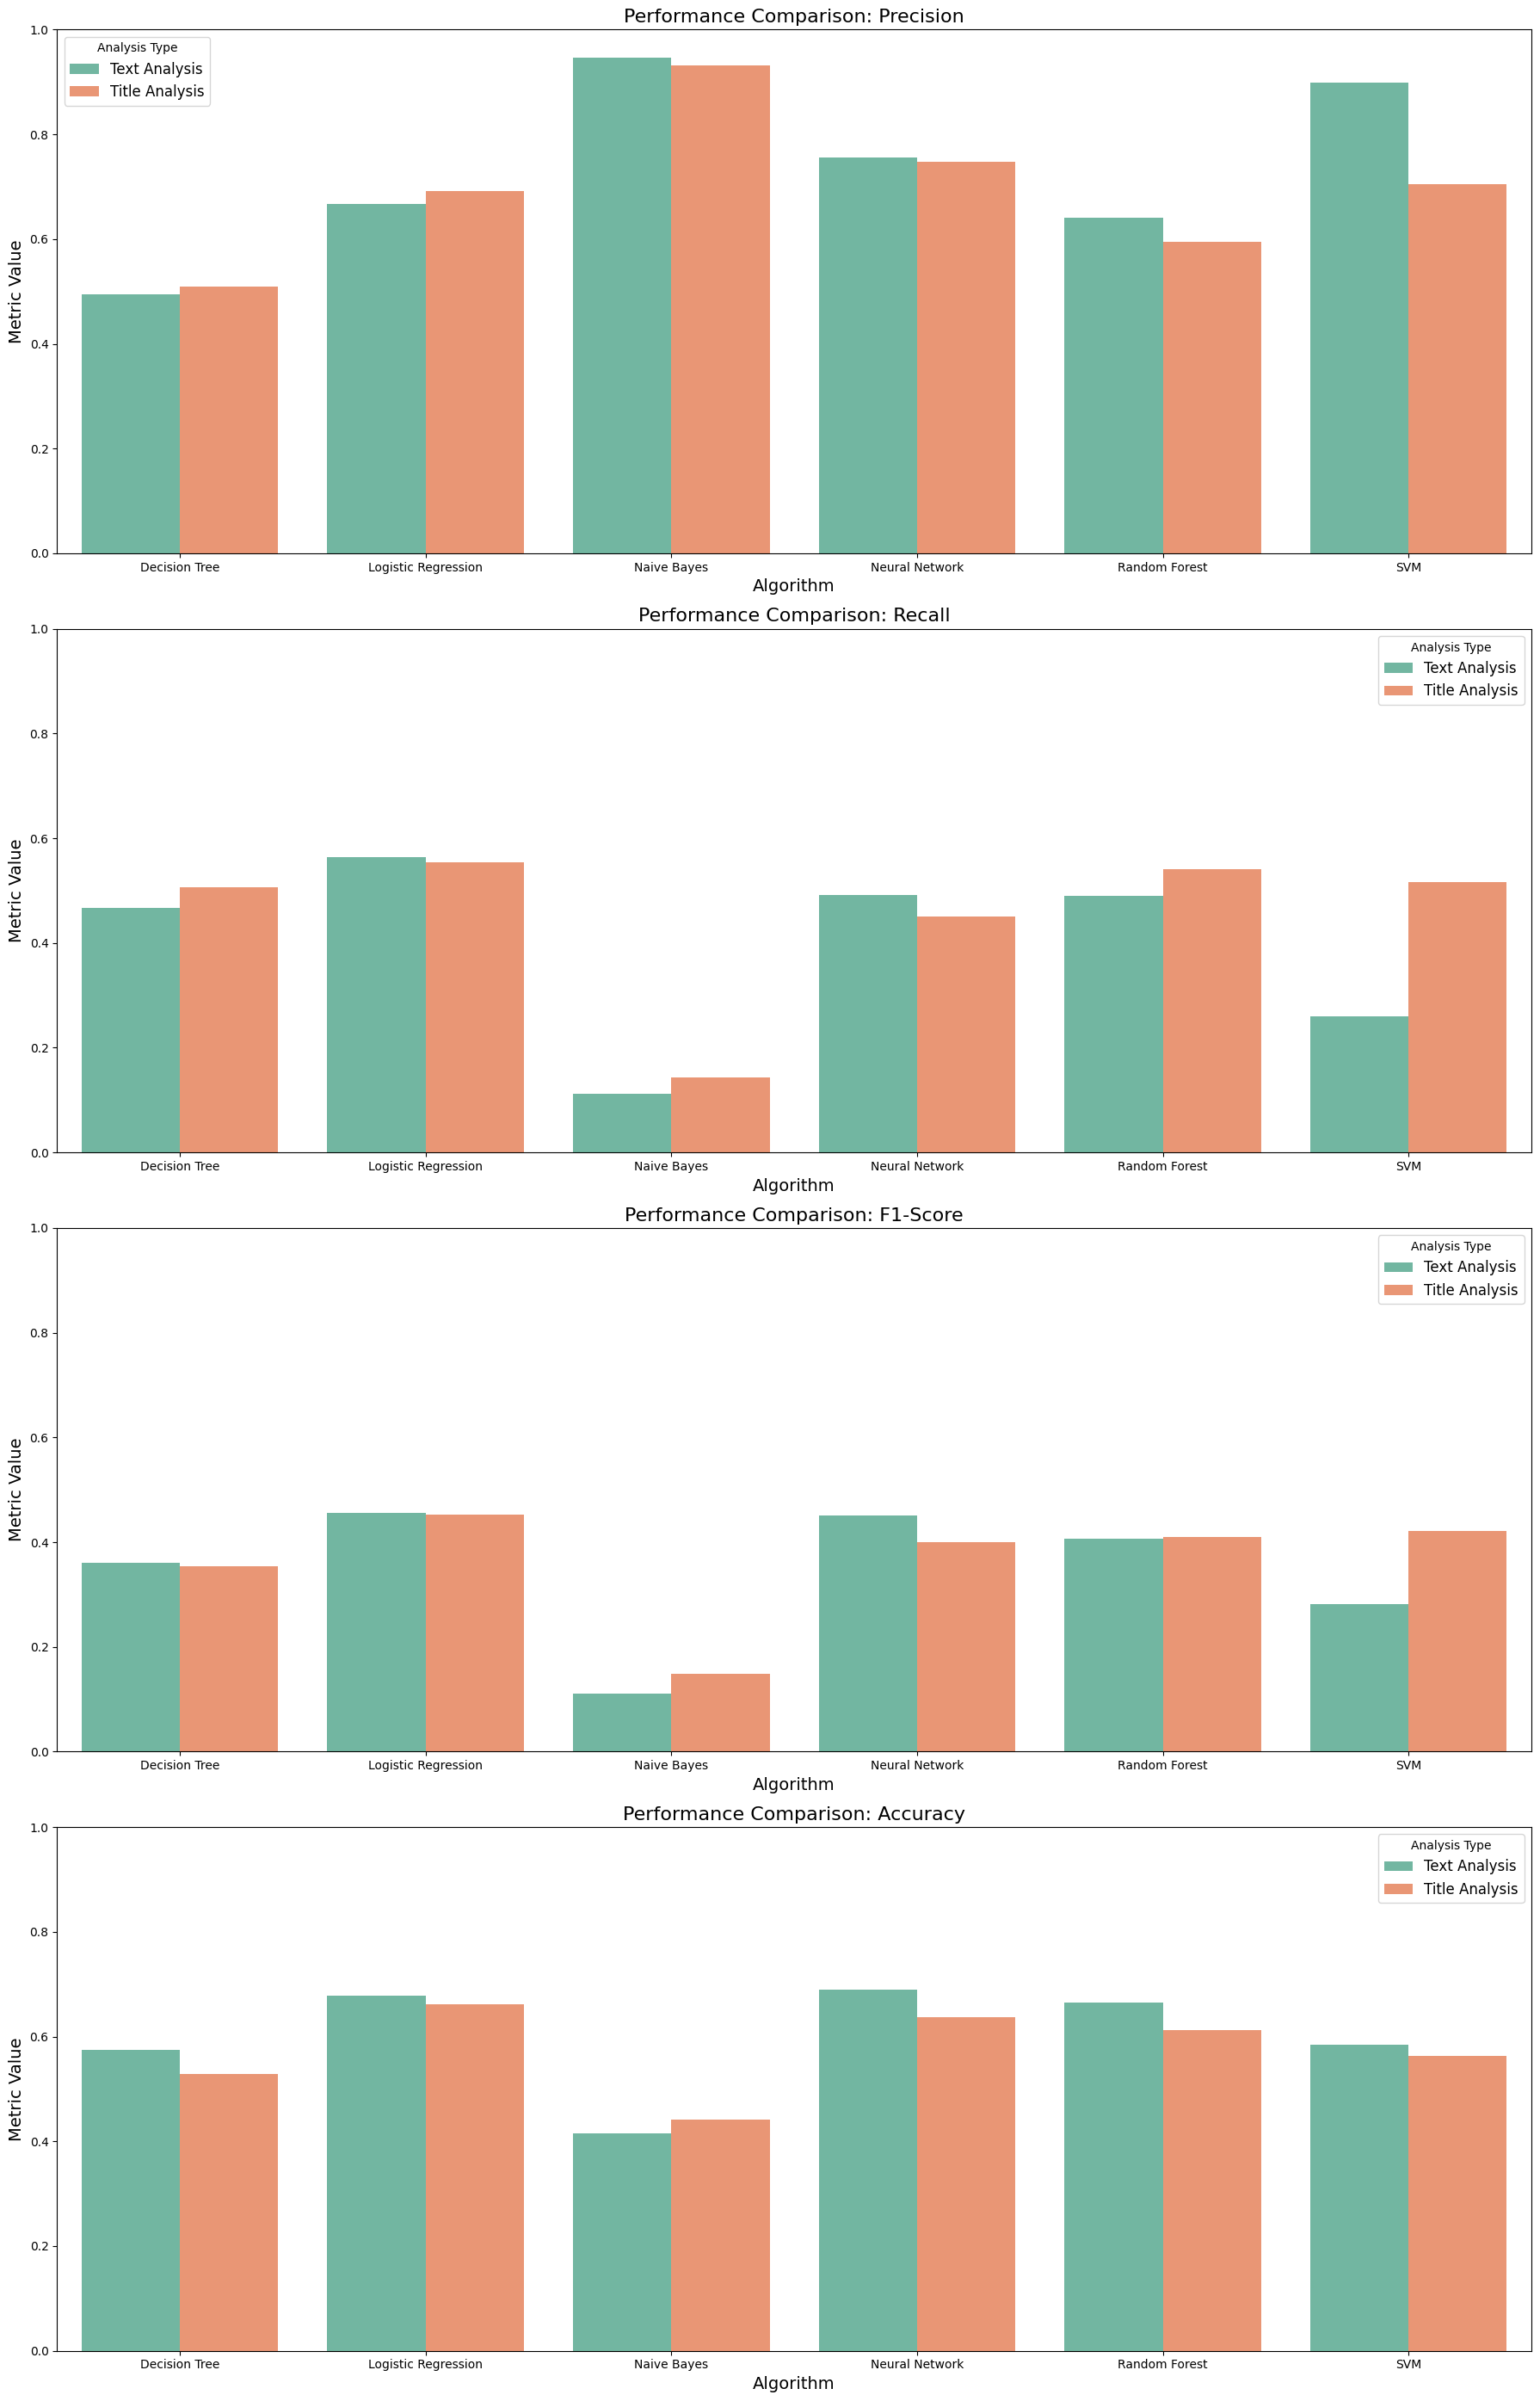

In [85]:
def plot_combined_metrics(combined_classification_pivot, combined_accuracy_pivot, categories):
    
    # Convert combined classification pivot to long format
    combined_classification_long = combined_classification_pivot.reset_index().melt(
        id_vars=['Algorithm', 'Analysis'], 
        var_name='Metric_Target', 
        value_name='Value'
    )
    combined_classification_long[['Metric', 'Target']] = combined_classification_long['Metric_Target'].str.split('_', expand=True)
    combined_classification_long = combined_classification_long.drop(columns='Metric_Target')

    # Convert combined accuracy pivot to long format
    combined_accuracy_long = combined_accuracy_pivot.reset_index().melt(
        id_vars=['Algorithm', 'Analysis'], 
        var_name='Target', 
        value_name='Value'
    )
    combined_accuracy_long['Metric'] = 'Accuracy'

    # Combine classification and accuracy metrics
    combined_metrics = pd.concat([combined_classification_long, combined_accuracy_long])

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(18, 28))  # One row for each metric
    metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

    for i, metric in enumerate(metrics):
        # Filter data for the current metric
        data = combined_metrics[combined_metrics['Metric'] == metric]

        # Plotting
        sns.barplot(
            data=data, 
            x="Algorithm", 
            y="Value", 
            hue="Analysis", 
            ax=axes[i], 
            palette="Set2",
            errorbar=None  # Disable error bars
        )

        axes[i].set_title(f"Performance Comparison: {metric}", fontsize=16)
        axes[i].set_xlabel("Algorithm", fontsize=14)
        axes[i].set_ylabel("Metric Value", fontsize=14)
        axes[i].legend(title="Analysis Type", fontsize=12)
        axes[i].set_ylim(0, 1)  # Metrics are between 0 and 1

    plt.tight_layout()
    plt.show()


# Define the categories for plotting
categories = ["hazard-category", "product-category", "hazard", "product"]

# Plot combined metrics for comparison
plot_combined_metrics(combined_classification_pivot, combined_accuracy_pivot, categories)

# Section 5: Validation Set

### Learning Curve

A **learning curve** is a graphical representation of a model's performance as a function of the training data size. It is used to understand how well a machine learning model is learning and generalizing to new, unseen data.

- **Training Curve**: Shows the model's performance on the training data. A high training score indicates that the model is fitting the training data well.
- **Validation Curve**: Represents the model's performance on validation data, serving as a proxy for generalization to unseen data.

**Key Insights from Learning Curves**:
- **Overfitting**: A large gap between the training and validation curves indicates overfitting.
- **Underfitting**: Low scores for both training and validation curves suggest underfitting.
- **Model Performance**: If the training and validation curves converge at a high score, the model is likely generalizing well.

In [89]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1, 5)):
    """
    Plots the learning curve for a given estimator.
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score (Macro)")

    stratified_cv = StratifiedKFold(n_splits=cv)

    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=stratified_cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Validation score")

    plt.legend(loc="best")
    plt.show()


# Function to plot learning curves for multiple algorithms
def plot_learning_curves_for_algorithms(algorithms, X, y, cv=5, n_jobs=-1):
    """
    Plots the learning curve for each algorithm in the given dictionary.
    
    Parameters:
    - algorithms: dictionary where keys are titles (str) and values are sklearn estimators
    - X: input features
    - y: target labels
    - cv: number of cross-validation splits
    - n_jobs: number of jobs to run in parallel
    """
    for title, estimator in algorithms.items():
        print(f"Plotting learning curve for: {title}")
        plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=n_jobs)

### Learning Curve on Text Analysis-TFIDF TECHNIQUE

Plotting learning curve for: Logistic Regression


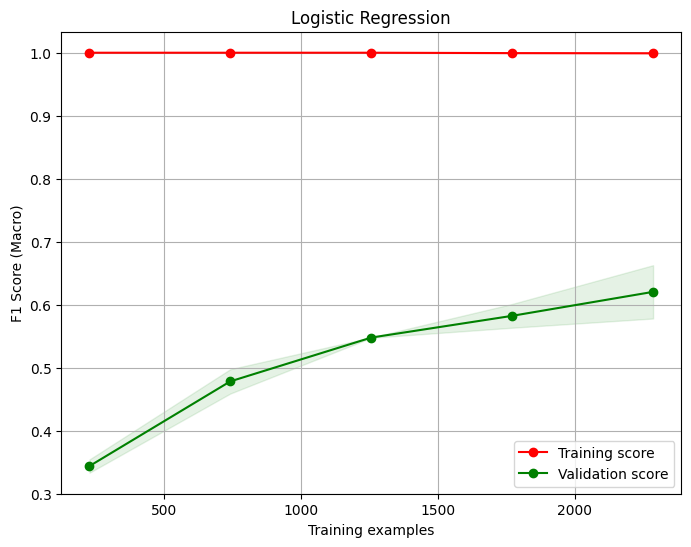

Plotting learning curve for: Decision Tree


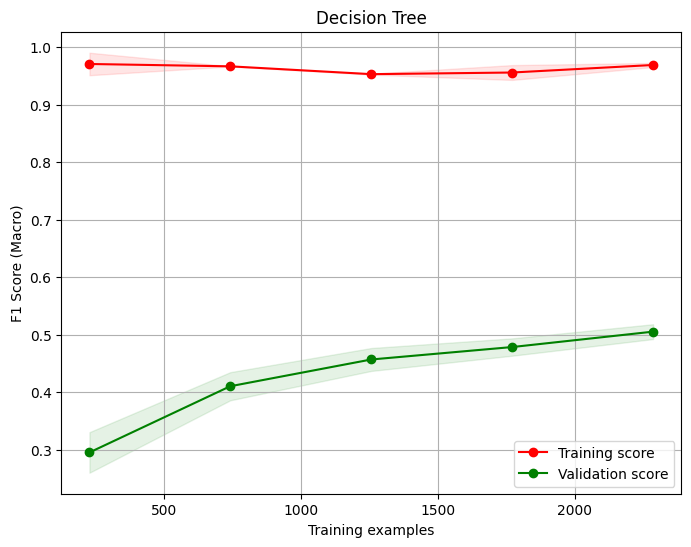

Plotting learning curve for: Naive Bayes


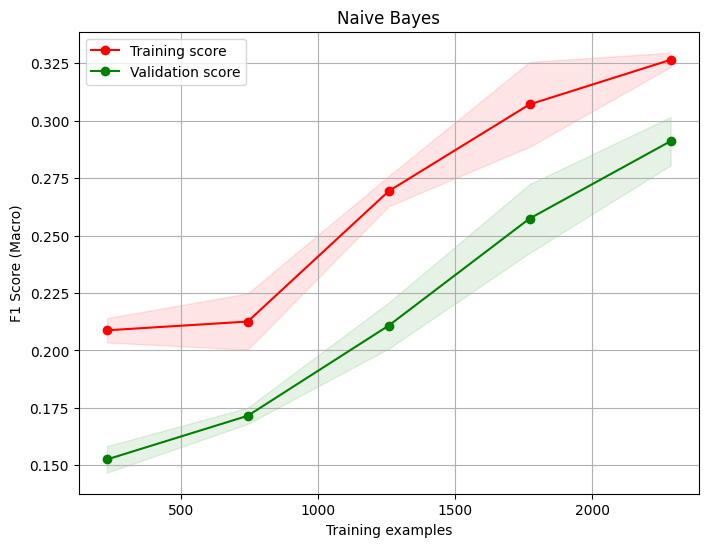

Plotting learning curve for: Random Forest


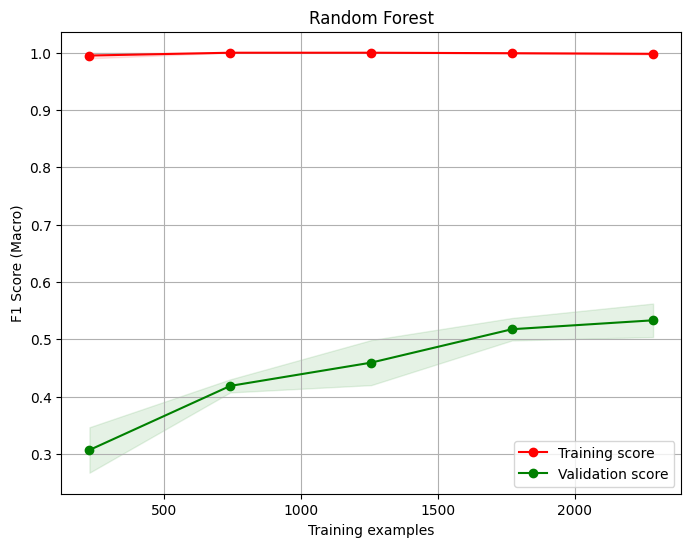

Plotting learning curve for: SVM


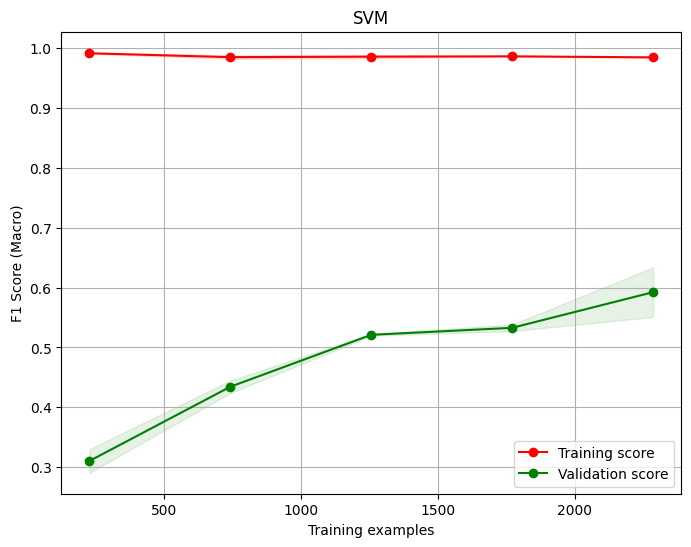

Plotting learning curve for: Neural Network


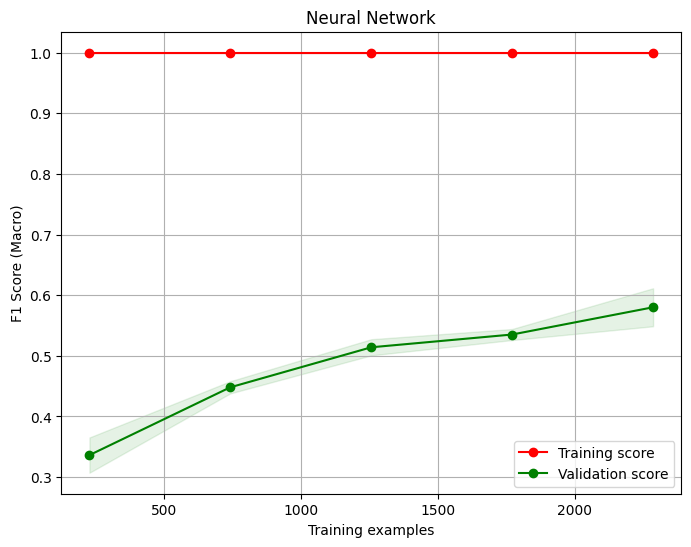

In [90]:
# Ensure y_train is properly formatted
if len(y_train_t.shape) == 1:
    y_train_flat = y_train_t
else:
    y_train_flat = y_train_t['hazard-category'].values.ravel()  # Adjust column as needed

# Ensure consistency in training data shape
assert X_train_tfidf_t.shape[0] == y_train_flat.shape[0]

# Dictionary of algorithms with titles
algorithms = {
    "Logistic Regression": LogisticRegression(C=20, solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=5, max_depth=None, random_state=42, class_weight='balanced'),
    "SVM": SVC(C=2, kernel='linear', random_state=42, probability=True, class_weight='balanced'),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', max_iter=1000, random_state=42)
}

# Call the function to plot learning curves
plot_learning_curves_for_algorithms(algorithms, X_train_tfidf_t, y_train_flat, cv=2, n_jobs=-1) #Text Analyis with TF-IDF Technique

### Learning Curve on Title Analysis-TFIDF TECHNIQUE

Plotting learning curve for: Logistic Regression


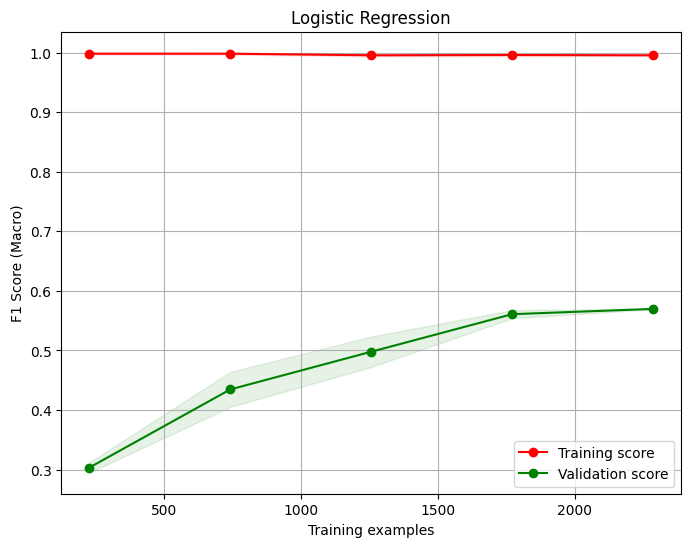

Plotting learning curve for: Decision Tree


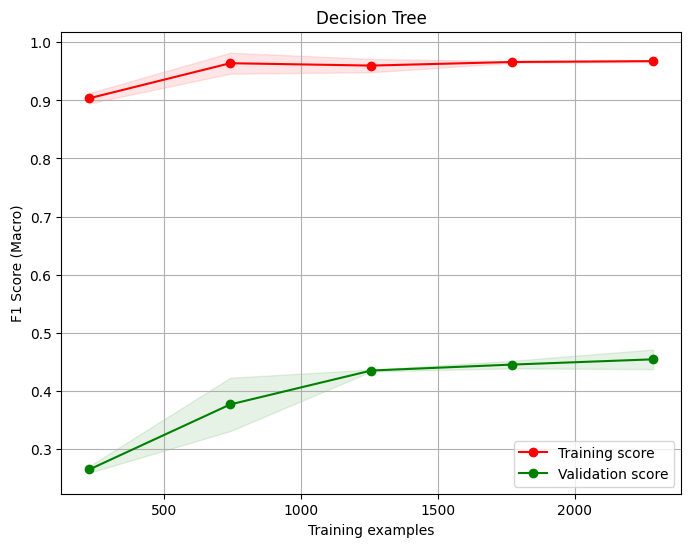

Plotting learning curve for: Naive Bayes


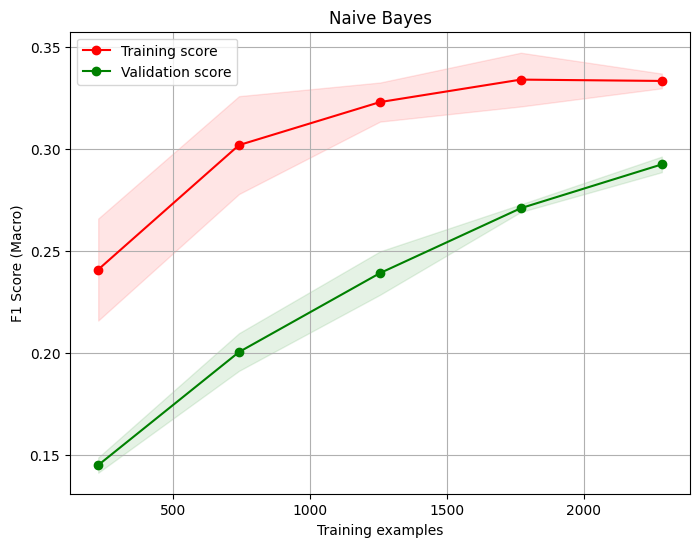

Plotting learning curve for: Random Forest


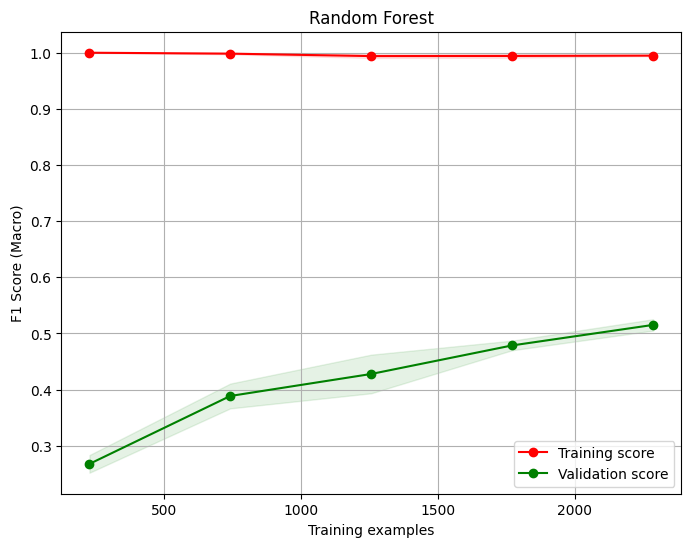

Plotting learning curve for: SVM


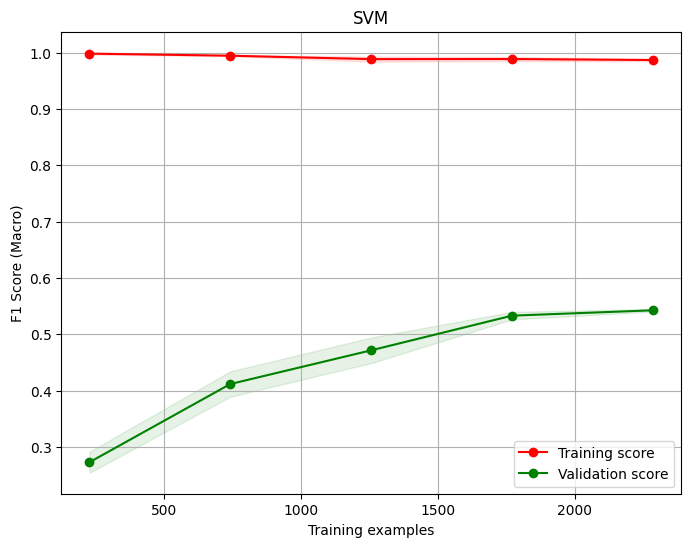

Plotting learning curve for: Neural Network


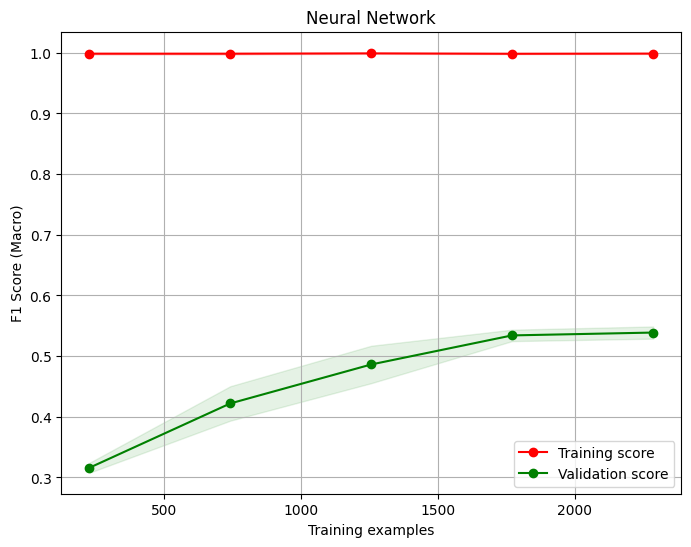

In [91]:
# Ensure y_train is properly formatted
if len(y_train.shape) == 1:
    y_train_flat = y_train
else:
    y_train_flat = y_train['hazard-category'].values.ravel()  # Adjust column as needed

# Ensure consistency in training data shape
assert X_train_tfidf.shape[0] == y_train_flat.shape[0]

# Dictionary of algorithms with titles
algorithms = {
    "Logistic Regression": LogisticRegression(C=20, solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=5, max_depth=None, random_state=42, class_weight='balanced'),
    "SVM": SVC(C=2, kernel='linear', random_state=42, probability=True, class_weight='balanced'),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', max_iter=1000, random_state=42)
}

# Call the function to plot learning curves
plot_learning_curves_for_algorithms(algorithms, X_train_tfidf, y_train_flat, cv=2, n_jobs=-1) #Title Analyis with TF-IDF Technique


## **SemEval 2025 Task 9: The Food Hazard Detection Challenge  - Scores**

#### **The best performance, in terms of F1 score for hazard-category & product-category, is achieved by the `SVC(C=2, kernel='linear', random_state=42, probability=True, class_weight='balanced')` algorithm using the BERT technique, with score = 0.2724.**

In [ ]:
file = pd.read_csv(r'/incidents-val.csv')
# Apply preprocessing to relevant columns
file['n_title'] = file['title'].apply(get_bert_embeddings)
file['n_long_text'] = file['text'].apply(get_bert_embeddings)

In [94]:
X_validation = np.stack(file['n_long_text'].values)  # Input: text column

In [95]:
# Initialize the base model (SVC)-Logistic Regression
best_model1 = SVC(C=2, kernel='linear', random_state=42, probability=True, class_weight='balanced')

# Wrap the model with MultiOutputClassifier to handle multi-output
multi_target_model = MultiOutputClassifier(best_model1, n_jobs=1)

# Train the model on the training data
multi_target_model.fit(X1_train, y1_train)

# Extract the predictions of the best model
y_pred_best1 = multi_target_model.predict(X_validation)

# Convert predictions to a DataFrame for inspection
predictions_df = pd.DataFrame(y_pred_best1, columns=['hazard-category', 'product-category', 'hazard', 'product'])

# Combine with original validation data (if needed for analysis)
file['hazard-category'] = predictions_df['hazard-category']
file['product-category'] = predictions_df['product-category']

#### **The best performance, in terms of F1 score for hazard & product, is achieved by the `RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42, class_weight='balanced')` algorithm using the TF-IDF technique, with score = 0.3765.**

In [96]:
# Apply preprocessing to validation set
file['n_title'] = file['title'].apply(preprocess_text)
file['n_long_text'] = file['text'].apply(preprocess_text)

X_validation_tfidf = vectorizer.transform(file['n_long_text'])

best_model3 = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42, class_weight='balanced')

# Wrap the model with MultiOutputClassifier to handle multi-output
multi_target_model = MultiOutputClassifier(best_model3, n_jobs=1)

# Train the model on the training data
multi_target_model.fit(X_train_tfidf_t, y_train_t)

# Extract the predictions of the best model
y_pred_best1 = multi_target_model.predict(X_validation_tfidf)

# Convert predictions to a DataFrame for inspection
predictions_df = pd.DataFrame(y_pred_best1, columns=['hazard-category', 'product-category', 'hazard', 'product'])

# Combine with original validation data (if needed for analysis)
file['hazard'] = predictions_df['hazard']
file['product'] = predictions_df['product']
